In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (20, 6)
from scipy import stats
import sqlite3
conn = sqlite3.connect('sample.sqlite')
import pandas as pd
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from keras import regularizers
from keras.layers import Dropout
from keras.layers import Dense
from keras import models
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from keras import models
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

# Task1 - Revenue Analysis


##### 1.Are there any revenue trends in the data? Visualise and explain your obser- vations.

As we can see throught the following figure, revenue meets its maximum around end of January. Additionally we can see a peak around March 26th which can be due to easter holidays. The same story goes about the increase regarding end of October which can be due to Halloween. It is interesting that the peak in March 26th co-occures with an increase in DNU, thus increase in revenue can be due to this fact as well. Might be UA  team Has been doing some use acquisition! 

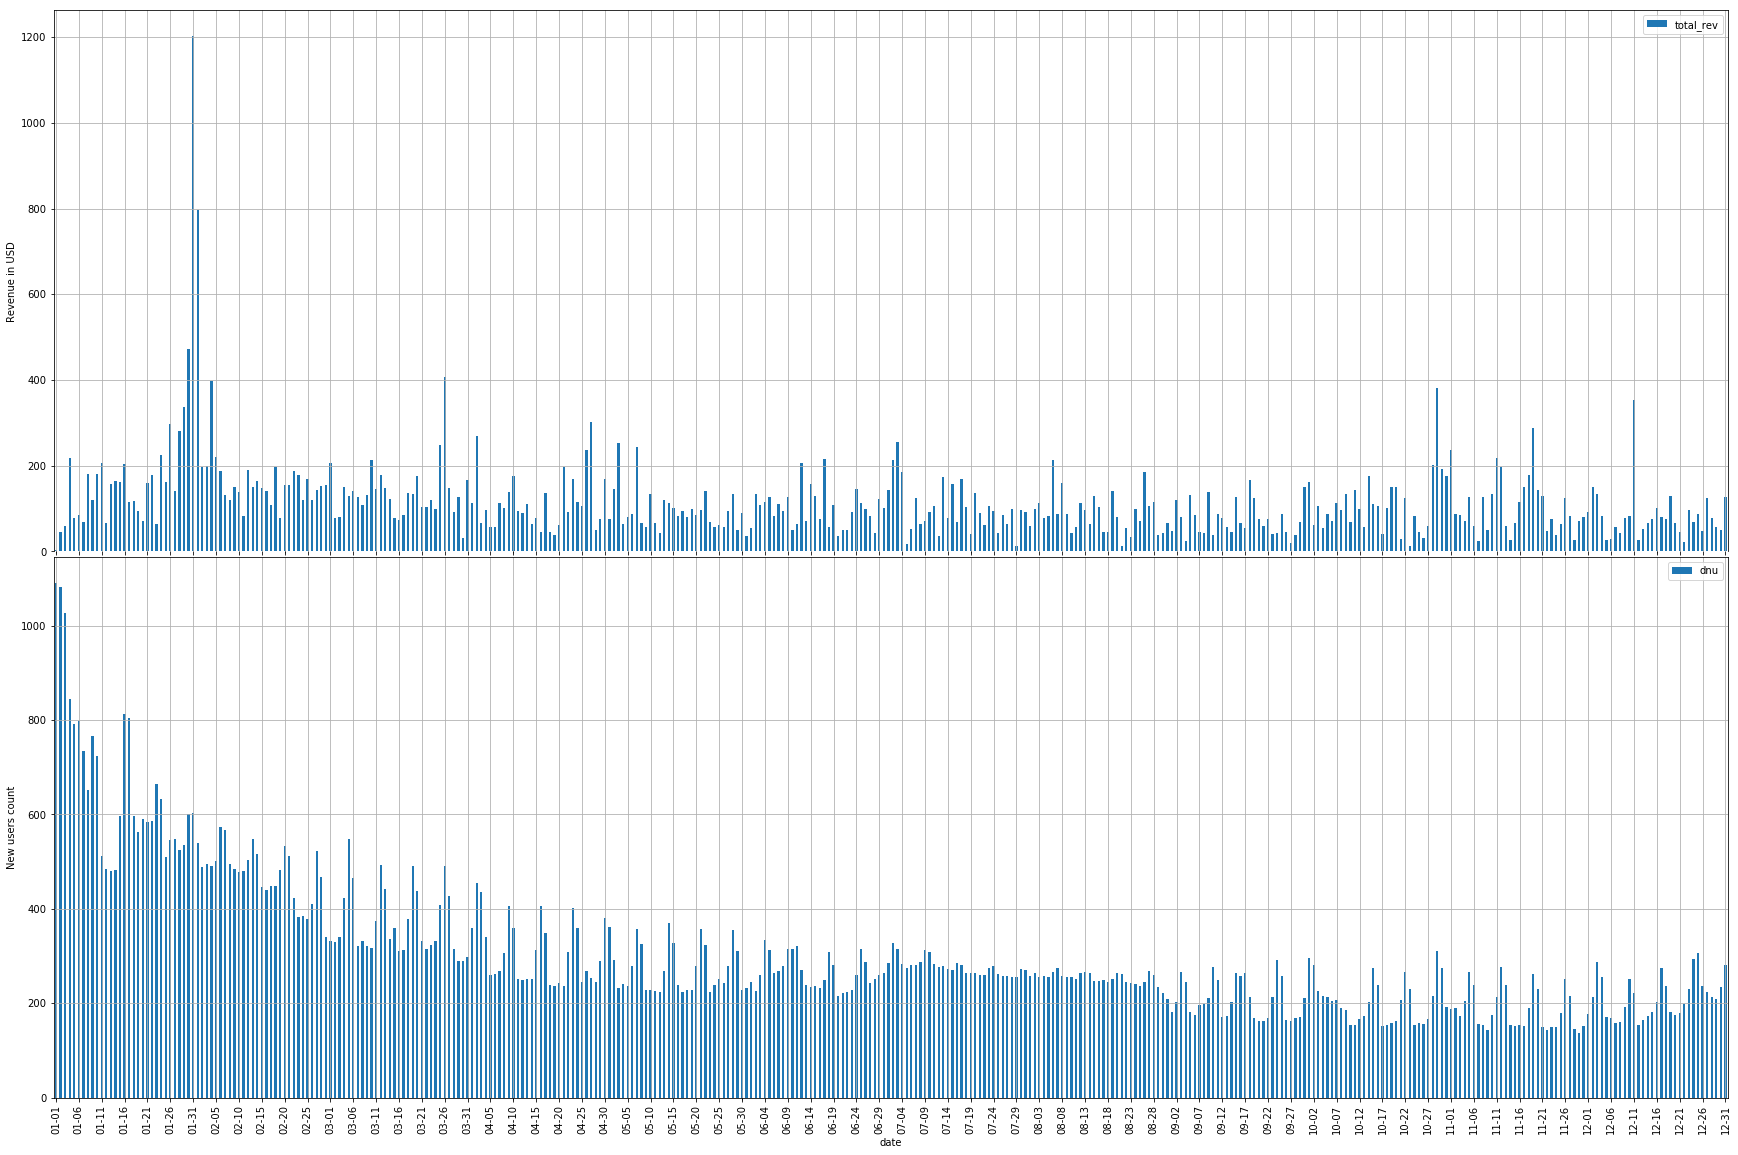

In [2]:
f, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(30,20))
f.subplots_adjust(hspace=0.01)
rev_in_each_day = """select strftime('%m-%d',date(created_time)) as date,
                     sum(iap_purchase.iap_price_usd_cents)/100 as total_rev 
                     from iap_purchase 
                     group by date"""
res = pd.read_sql_query(rev_in_each_day, conn)
ax = res.plot('date', 'total_rev', ax=ax,  kind='bar' )
ax.spines['bottom'].set_visible(False)
ax.grid(True)
ax.set_ylabel('Revenue in USD')

dnu_in_each_day_sql = """select strftime('%m-%d', created_time) as date, count(account_id) as dnu 
                     from account
                     group by date"""

dnu_pd = pd.read_sql_query(dnu_in_each_day_sql, conn)
dnu_pd.plot('date', 'dnu', ax=ax2, kind='bar')
ax2.set_ylabel('New users count')

x_ticks = np.arange(0, 366, 5)
_ = plt.xticks(x_ticks, [list(res['date'])[i] for i in x_ticks], rotation=90)
ax2.grid(True)

##### Analyse the geographic split of the revenue. What are your observations of the results?
Through the following chart you can find the geograohical reveue share for top 10 countries (sorted base on revenue).
It also includes some information regarding the number of paying users of each country and the average money spent by each paying user. It is an interesting observation that Americans, while contribute to the revenue with fewer number of players (as compared to the Chinese paying users), are the strogngest paying users as the average money paid by Amirican users is three times more than the average moeny paid by Chinese users!

In [3]:
geographical_split_query = """select country_code, 
       sum(iap_price_usd_cents) as rev_in_USD_cents,
       count(distinct(a.account_id)) as geographical_population,
       sum(iap_price_usd_cents)/count(distinct(a.account_id)) as avg_USD_cents_per_user
       from(
        iap_purchase a        
        left join account b
        on a.account_id = b.account_id)
        group by country_code
        order by rev_in_USD_cents desc, avg_USD_cents_per_user desc
"""

geographical_split_pd = pd.read_sql_query(geographical_split_query, conn)
geographical_split_pd.head(10)

country_code  rev_in_USD_cents  geographical_population  \
0           US           1314818                      248   
1           CN           1136507                      874   
2           KR            463518                       72   
3           CA            254506                       42   
4           TR            193339                       20   
5           CH            182774                        9   
6           FR            152739                       56   
7           GB            145086                       57   
8           DE             94621                       32   
9           CO             45860                        1   

   avg_USD_cents_per_user  
0                    5301  
1                    1300  
2                    6437  
3                    6059  
4                    9666  
5                   20308  
6                    2727  
7                    2545  
8                    2956  
9                   45860

##### 3.What proportion of lifetime revenue is generated on the player’s first week in game?

First we create a data frame which is created based on merging account table and iap_purchase tables and adding a column as "purchase_week" which stands for the week (since the player has joined the game) that the purchase has made in. 

In [4]:
total_rev_sql = """
select a.account_id,
       strftime('%Y-%m-%d' , b.created_time) as first_play_date,
       strftime('%Y-%m-%d' , a.created_time) as first_purchase_date,
       cast((julianday(strftime('%Y-%m-%d' , a.created_time)) - 
       julianday(strftime('%Y-%m-%d' , b.created_time))) / 7 as int) as purchase_week,
       a.iap_price_usd_cents as payment
      from 
        iap_purchase as a
        left join account as b
        on a.account_id = b.account_id
"""
total_rev_pd = pd.read_sql_query(total_rev_sql, conn)
total_rev_pd.head(5)

account_id first_play_date first_purchase_date  purchase_week  payment
0  30077202816      2016-01-23          2016-03-26              9      739
1  30077202816      2016-01-23          2016-05-31             18      369
2  21487283560      2016-01-16          2016-02-13              4      184
3  21487152816      2016-01-09          2016-02-28              7      184
4   8602037685      2016-01-02          2016-02-11              5      184

Now using this dataframe we can calculate total revenue and the revenue generated by paymens made in the first week.

In [5]:
total_rev =  total_rev_pd.payment.sum()
rev_from_first_week = total_rev_pd.ix[total_rev_pd['purchase_week'] == 0]['payment'].sum()
print "The proportion is: %.3f" %(float(rev_from_first_week)/total_rev)

The proportion is: 0.171


# Explore

In this section I will try to make some points regarding the importance of convergence time. In this section I refer to convergence time as the number of weeks required for a player to converge and turn to a paying user. By the way of example, if a user start paying for a package in the game during the same week that he/she has started the game, then the convergence has happened during week 0. Thus through this section "time" is defined at user's level. As another example, day0 means the day that player has entered the game, day 1 stands for the next day the the user has played the game and so on.

Now that we have all the basics in palce, we can take a look at the following figure to get a feeling about how users behave!. Through the following figure, three different metrics are depicted:
* total time played by all users: which depicts the total session time by all users. By the way of example, total session at day 0 (~ 200K) means that, in total, players have played the game for 200k minutes during the day they installed the game (day 0).

* number of active users: stands for the number of people who have played the game during day X since they entered the game. By the way of example, number of active users in day 0 (regarding day 0 as the day that the game has been installed) is about 110K.

* average daily time played per active user: which can be obtained from diving the above numbers. This simply means the average play time that a player spends after installing the game.

One interesting observation is that we can observe a sudden drop in number of active users, while we observe a gradual decrease in the total time played by all users. This measnt that while we lose some users during the early weeks (and cnosequntly drop occoures in total played time), the remaining users spend more time and can compensate the session time lost from leaving users. That is why the average time stays almost steady during.

In [3]:
dau_avg_played_query = """
select  day, 
         count((account_id)) as daily_active_user,
         sum(total_time_played)/60 total_daily_time_played,
         (sum(total_time_played)/60)/count((account_id)) as avg_time_played_per_active_user
 from(        
        select day, account_id,  sum(session) as total_time_played
        from(
                select  duration_table.account_id as account_id,
                        duration_table.date as play_date,
                        duration_table.session_duration_sec as session,
                        strftime('%Y-%m-%d', first_play_date.first_play_date) as first_play,
                        julianday(duration_table.date) - 
                        julianday(strftime('%Y-%m-%d', first_play_date.first_play_date)) as delt_time,
                        cast((julianday(duration_table.date) - 
                            julianday(strftime('%Y-%m-%d', first_play_date.first_play_date)))
                            as int)  as day
                        from( 
                        (select account_id,
                                date,
                                session_duration_sec
                         from account_date_session ) duration_table
                         left join (
                         select account_id, created_time as first_play_date
                         from account) first_play_date
                         on duration_table.account_id = first_play_date.account_id
                         )
                         
                 )
                 
                 group by 1,2
        )
        group by 1
 
"""
dau_avg_played_pd = pd.read_sql_query(dau_avg_played_query, conn)

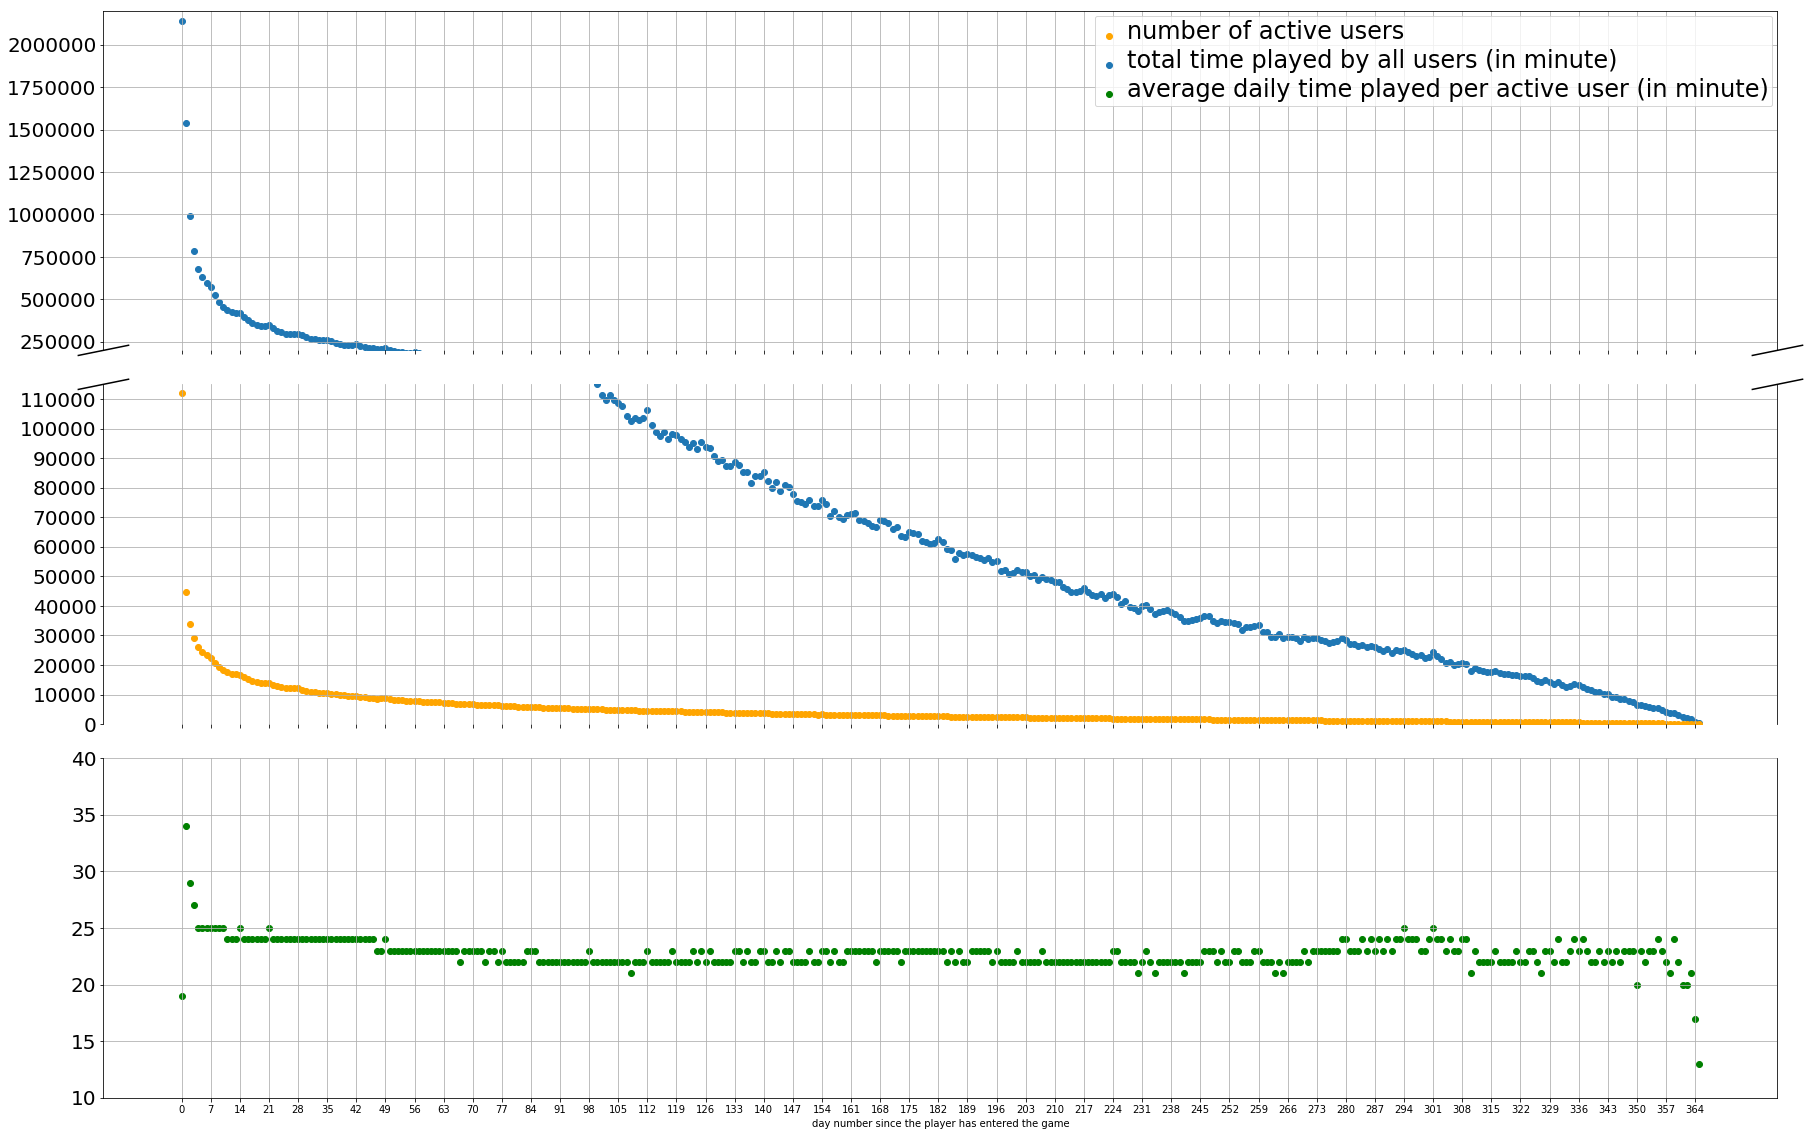

In [19]:
f, (ax, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(30,20))

f.subplots_adjust(hspace=0.1)
ax.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['daily_active_user'], color='orange', label='number of active users')
ax.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['total_daily_time_played']
           , label='total time played by all users (in minute)')
ax.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['avg_time_played_per_active_user'], color='green',
        label='average daily time played per active user (in minute)')

ax2.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['total_daily_time_played'])
ax2.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['daily_active_user'], color='orange')
#ax2.plot(dau_avg_played_pd['day'], dau_avg_played_pd['avg_time_played_per_active_user'], color='green')

ax3.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['total_daily_time_played'])
#ax3.plot(dau_avg_played_pd['day'], dau_avg_played_pd['daily_active_user'], color='orange')
ax3.scatter(dau_avg_played_pd['day'], dau_avg_played_pd['avg_time_played_per_active_user'], color='green')

ax.set_ylim(200000, 2200000)
ax2.set_ylim(0, 115000)
ax2.set_yticks(np.arange(0, 115000, 10000))
ax3.set_ylim(10, 40)

ax.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax.tick_params(labeltop='off') 
ax2.tick_params(labeltop='off') 
ax3.xaxis.tick_bottom()

d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)    
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)



legend = ax.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='24')
ax.set_xticks(np.arange(0,365,7))
ax.grid(True)
ax2.grid(True)
ax3.grid(True)

ax3.set_xlabel('day number since the player has entered the game')
plt.rcParams['ytick.labelsize'] = 20

We can do the same analysis, and get similar numbers for each week that the user has played a game. This figure also corroborates the observation that we made above. 

In [17]:
wau_avg_played_query = """
select  week, 
         count((account_id)) as weekly_active_user,
         sum(total_time_played)/60 total_weekly_time_played,
         (sum(total_time_played)/60)/count((account_id)) as avg_time_played_per_active_user
 from(        
        select week, account_id,  sum(session) as total_time_played
        from(
                select  duration_table.account_id as account_id,
                        duration_table.date as play_date,
                        duration_table.session_duration_sec as session,
                        strftime('%Y-%m-%d', first_play_date.first_play_date) as first_play,
                        julianday(duration_table.date) - julianday(strftime('%Y-%m-%d', first_play_date.first_play_date)) as delt_time,
                        cast((julianday(duration_table.date) - 
                            julianday(strftime('%Y-%m-%d', first_play_date.first_play_date)))/7
                            as int)  as week
                        from( 
                        (select account_id,
                                date,
                                session_duration_sec
                         from account_date_session ) duration_table
                         left join (
                         select account_id, created_time as first_play_date
                         from account) first_play_date
                         on duration_table.account_id = first_play_date.account_id
                         )
                         
                 )
                 
                 group by 1,2
        )
        group by 1
 
"""
wau_avg_played_pd = pd.read_sql_query(wau_avg_played_query, conn)

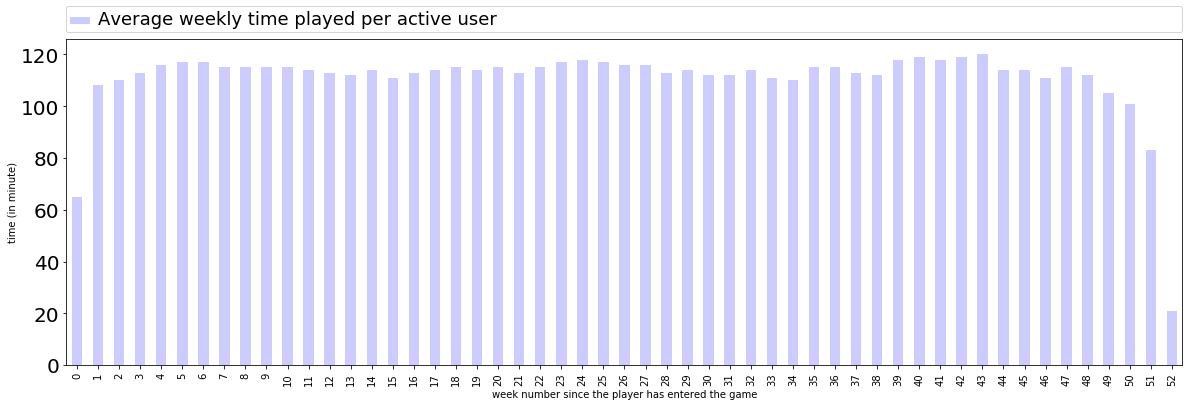

In [30]:
f , ax = plt.subplots(1,1)
wau_avg_played_pd.plot(kind='bar', x='week', y='avg_time_played_per_active_user', color =  (0, 0, 1, 0.2), ax=ax
                      , label = 'Average weekly time played per active user')

ax.set_ylabel('time (in minute)')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

plt.setp(ax.get_legend().get_texts(), fontsize='18')
ax.set_xlabel('week number since the player has entered the game')

Now let's take a look at first convergence value. The first convergence (general convergence) is defined as the ratio of total number of players who has paid at least onece (converged) divided by the number of total users. In this case the general convergence is going to be: 1549/112792 which results in 0.013!

The point is that we can look at the convegence in a different way. In a weekly basis, we can define the weekly convergence rate as the number of users who are going to pay for the first time duing that week divided by the number of users who have been active (played) the game during that week and have not yet paid for the game (that is **EXCLUDING** people who have paid for the game during the past weeks). By the way of example, week0 convergence is going to be the number of users who are going to pay for the first time during the first week of the game divided by number of people who have played the game during the week that they have installed the game. Similarly, week1 convergence rate is going to be, the number of users who are going to pay for the first time during the second week, divided by the number of people who have been active during the second week (and have not paid for the game during week0)!

Based on this definition we can generate the following figure. It is pretty interesting to observe that the ratio decreses through the early weeks (which is quite expected) but it meets a peak on week 46!

In [170]:
converged_users_query = """
select strftime('%Y-%m-%d', a.created_time) as first_purchase_date,
               strftime('%Y-%m-%d', b.created_time) as first_play_date,
               a.account_id,
               cast((julianday(strftime('%Y-%m-%d', a.created_time)) - 
               julianday(strftime('%Y-%m-%d', b.created_time)) ) /7 as int) as week_number
               
                from (
                (select account_id, min(created_time) as created_time from iap_purchase
                group by account_id) as a
                left join account as b
                on a.account_id = b.account_id)
"""

weekly_active_users_query = """
select  a.account_id,
        cast ((julianday(a.date) - julianday(strftime('%Y-%m-%d', b.created_time)))/7 as int) as week
        from 
        account_date_session as a 
        left join account as b
        on a.account_id = b.account_id
        group by a.account_id, week 
""" 
weekly_active_users_pd = pd.read_sql_query(weekly_active_users_query, conn)
converged_users_pd = pd.read_sql_query(converged_users_query, conn)

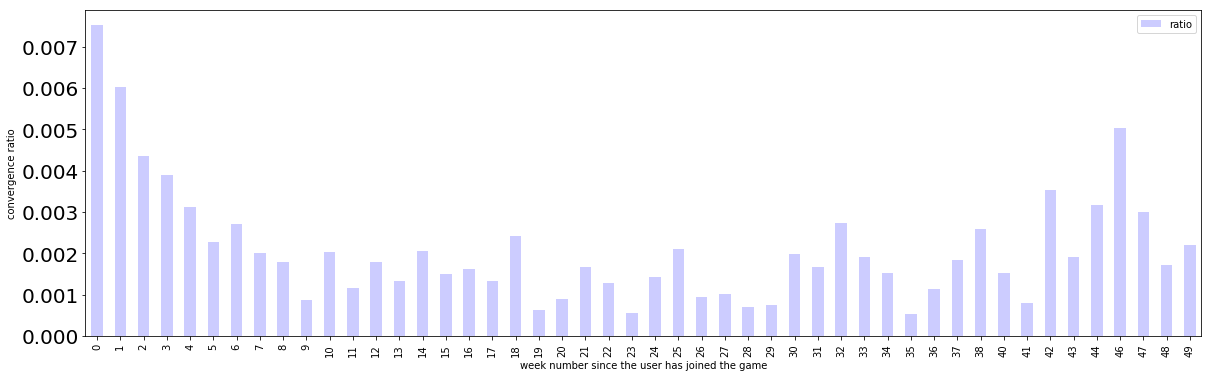

In [177]:
weeks_list = []
not_paid_users_of_this_week_list = []
total_users_converged_this_week_list = []

for week in xrange(0,52):
    #print week
    active_users_ids = weekly_active_users_pd.ix[weekly_active_users_pd['week'] == week]['account_id'].tolist()
    if converged_users_id.ix[converged_users_id['week_number'] < week]['account_id'].empty:
        already_converged_until_this_week_users_ids = []
    else:
        already_converged_until_this_week_users_ids =  converged_users_id.ix[converged_users_id['week_number'] < week]['account_id'].sum()
    
    not_paid_users_of_this_week = len(set(active_users_ids) - set(already_converged_until_this_week_users_ids))
    
    if converged_users_id.ix[converged_users_id['week_number'] == week]['account_id'].empty:
        continue
    total_users_converged_this_week = len(converged_users_id.ix[converged_users_id['week_number'] == week]['account_id'].item())
    
    weeks_list.append(week)
    not_paid_users_of_this_week_list.append(not_paid_users_of_this_week)
    total_users_converged_this_week_list.append(total_users_converged_this_week)

    
weekly_convergence_pd = pd.DataFrame({'week': weeks_list,
                                      'not_paid_users': not_paid_users_of_this_week_list,
                                      'converged_users': total_users_converged_this_week_list})

weekly_convergence_pd['ratio'] = weekly_convergence_pd['converged_users']/weekly_convergence_pd['not_paid_users']

f, ax = plt.subplots(1,1)
weekly_convergence_pd.plot(kind='bar', x='week', y='ratio', ax=ax, color=(0, 0, 1, 0.2))
ax.set_xlabel('week number since the user has joined the game')
ax.set_ylabel('convergence ratio')


We can take a deeper look at only the paid users. let's analyze during which week (since joining the game) the first payment has occured. We can see the results through the following figure. It is pretty interesting to observe that around 800 of the toatal paying user has done the first purchase during the first week (which is almost 55% of the paying users). Additionally, 11.62% of paying users have done their first payment during the second week. 

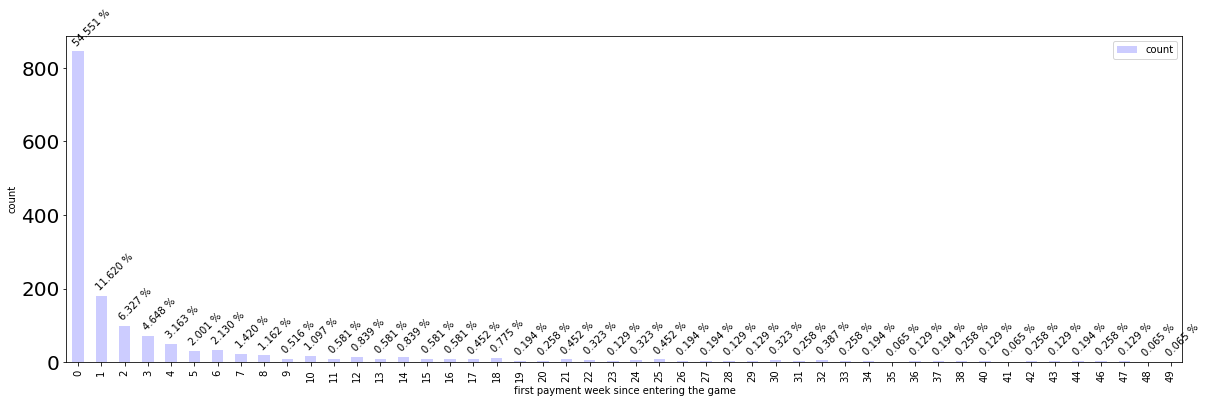

In [178]:
weeks_required_to_coverge_query="""
select week_number, count(account_id) as count from( 
        select strftime('%Y-%m-%d', a.created_time) as first_purchase_date,
               strftime('%Y-%m-%d', b.created_time) as first_play_date,
               a.account_id,
               cast((julianday(strftime('%Y-%m-%d', a.created_time)) - 
               julianday(strftime('%Y-%m-%d', b.created_time)) ) /7 as int) as week_number
               
                from (
                (select account_id, min(created_time) as created_time from iap_purchase
                group by account_id) as a
                left join account as b
                on a.account_id = b.account_id)
           )
           group by week_number
"""

weeks_required_to_coverge_pd= pd.read_sql_query(weeks_required_to_coverge_query, conn)
ax = weeks_required_to_coverge_pd.plot(kind='bar', x='week_number', y='count', label='count', color=(0, 0, 1, 0.2))

bbox = {}
for rect in ax.patches:
    
    height =  rect.get_height()
    percentage = float(height)/weeks_required_to_coverge_pd['count'].sum()
    plt.text(rect.get_x() - 0.05, rect.get_height() + 10,"%.3f %%" %(percentage*100)
             , {'ha': 'left', 'va': 'bottom', 'bbox': bbox}, rotation = 45)

ax.set_xlabel('first payment week since entering the game')
ax.set_ylabel('count')

Now let's take a look at the revenue genrate by paying users. It is fascinating to observe that  almost 68% of the total lifetime revenue is generated by the paying users who has done their payment in the first week. The following figure after the next one, depicts the cumulative sum of the revenue generated by paying users. It vividly states the fact that **90% (95%)** of the lifetime revenue is generated by the paying users who have done their first payment within the first **5 (8)** weeks of playing the game.

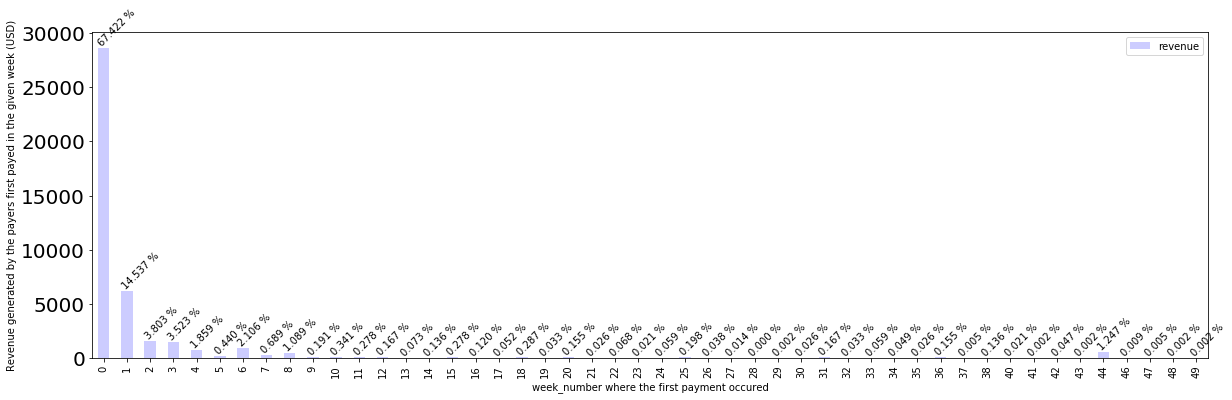

In [180]:
revenue_by_similar_first_payment_week_cohort_sql = """
select week_number, sum(iap_price_usd_cents)/100 as revenue 
        from(
                (select strftime('%Y-%m-%d', a.created_time) as first_purchase_date,
                       strftime('%Y-%m-%d', b.created_time) as first_play_date,
                       a.account_id,
                       cast((julianday(strftime('%Y-%m-%d', a.created_time)) - 
                       julianday(strftime('%Y-%m-%d', b.created_time)) ) /7 as int) as week_number
                       
                        from (
                        (select account_id, min(created_time) as created_time from iap_purchase
                        group by account_id) as a
                        left join account as b
                        on a.account_id = b.account_id)) as x_th_week_first_purchase
                   left join iap_purchase
                   on x_th_week_first_purchase.account_id = iap_purchase.account_id
              )
              group by week_number
"""
revenue_by_similar_first_payment_week_cohort_pd = pd.read_sql_query(revenue_by_similar_first_payment_week_cohort_sql, conn)
ax = revenue_by_similar_first_payment_week_cohort_pd.plot(kind='bar', x='week_number', y='revenue', color=(0, 0, 1, 0.2))

bbox = {}
for rect in ax.patches:
    
    height =  rect.get_height()
    percentage = float(height)/revenue_by_similar_first_payment_week_cohort_pd['revenue'].sum()
    plt.text(rect.get_x() - 0.05, rect.get_height() + 10,"%.3f %%" %(percentage *  100)
             , {'ha': 'left', 'va': 'bottom', 'bbox': bbox}, rotation = 45)

ax.set_ylabel('Revenue generated by the payers first payed in the given week (USD)')
ax.set_xlabel('week_number where the first payment occured')

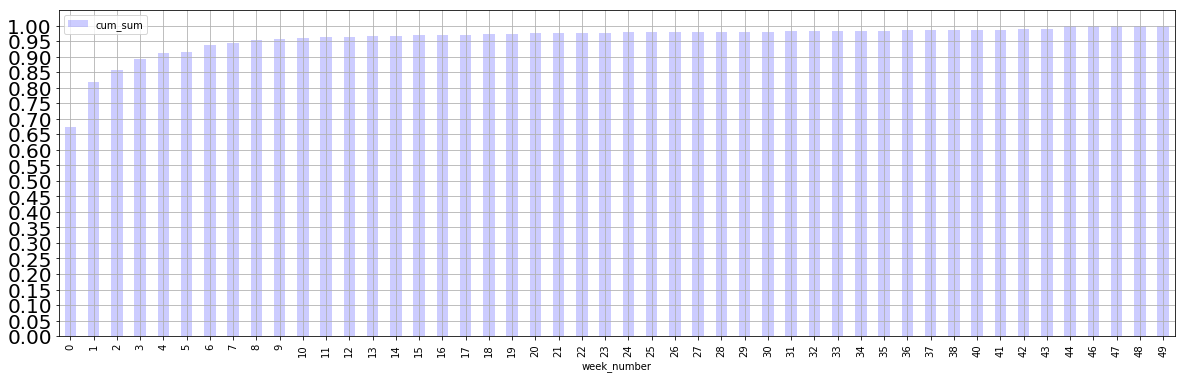

In [181]:
revenue_by_similar_first_payment_week_cohort_pd['normalized'] = revenue_by_similar_first_payment_week_cohort_pd['revenue']\
                                                              /revenue_by_similar_first_payment_week_cohort_pd['revenue'].sum()
revenue_by_similar_first_payment_week_cohort_pd['cum_sum'] = revenue_by_similar_first_payment_week_cohort_pd['normalized'].cumsum()    
ax = revenue_by_similar_first_payment_week_cohort_pd.plot(x='week_number', y='cum_sum',kind='bar', color=(0, 0, 1, 0.2))
ax.grid(True)
_ticks = ax.set_yticks(np.arange(0,1.05,.05))



This clearly means that the first **5-8** weeks (since the player has joined the game) is a golden time to turn a free user to a paying one, as it is crystal clear that paying users who start the payment during the aformentioned weeks can generate great amount of lifetime revenue. In order to do so, one can use the average weekly played time depicted before, in orer to get some feeling that, on average, how much a player plays the game during the early weeks of joining the game, and on average how much time is avaliable to turn a free user to a paying one. 

Additionally we can take a look at the geographical split of the paying payers through the first 8 weeks. These number are summarized throgh the following table. 

In [183]:
country_distrubion_first_payers_query= """
select week_number, country_code, count(country_code) as count 
from (
       (select strftime('%Y-%m-%d', a.created_time) as first_purchase_date,
               strftime('%Y-%m-%d', b.created_time) as first_play_date,
               a.account_id,
               cast((julianday(strftime('%Y-%m-%d', a.created_time)) - 
               julianday(strftime('%Y-%m-%d', b.created_time)) ) /7 as int) as week_number
               from (
               
                (select account_id, min(created_time) as created_time from iap_purchase
                group by account_id) as a
                left join account as b
                on a.account_id = b.account_id)) as first_payment_week
                left join account
                on first_payment_week.account_id = account.account_id)
                group by week_number, country_code
                order by week_number asc, count desc
"""
country_distrubion_first_payers_pd = pd.read_sql_query(country_distrubion_first_payers_query, conn)

In [185]:
pd.pivot_table(country_distrubion_first_payers_pd[['week_number', 'country_code','count']],
               index=['week_number', 'country_code']).ix[0:8]\
              .reset_index().sort_values(['week_number', 'count'], ascending=[True, False])\
              .groupby('week_number').head(5)


week_number country_code  count
8              0           CN    483
35             0           US    136
22             0           KR     36
14             0           FR     31
15             0           GB     29
41             1           CN     96
54             1           US     26
50             1           KR     12
39             1           CA      9
46             1           GB      8
58             2           CN     51
68             2           US     20
64             2           KR      6
57             2           CA      3
59             2           DE      3
70             3           CN     42
80             3           US     12
72             3           FR      5
73             3           GB      4
74             3           KR      2
84             4           CN     24
93             4           US      6
87             4           GB      3
88             4           KR      3
91             4           RU      3
95             5           CN     17
101            5           US      4
96             5           DE      2
99             5           KR      2
100            5           TR      2
105            6           CN     18
109            6           US      6
108            6           KR      3
102            6           AU      2
103            6           BE      1
112            7           CN     12
117            7           US      3
115            7           KR      2
110            7           BE      1
111            7           CA      1
120            8           CN     12
121            8           KR      2
118            8           AU      1
119            8           CA      1
122            8           US      1

Based on these numbers we can make another amazing observation! Through all the first eight weeks, Chinese payers form the majority of the payers. In otehr words, through the cohort of the paying users who start the payment during week 0, Chinese payers form the majority which is three times more than the US payers as the runner up. But keep in mind that based on the geographic revenue split, US payers are the first contributers to lifetime revenue, while chinese where the runner up there. This means that while Chinese might not be as strong as US paying players (in doing payments and contribute to lifetime revenue), but they have a great potential to converge and turn to a pying user. This means that if we are able to run a campaign for Chinese players (by creating sale packages and etc..) we can increase the lifetime revenue and also increase their revenue share.

Based on this, it can be interesting to take a look at the Chinise market (regarding paying users) and check where the revenue is coming from. The following Pie charts depict the revenue share of the chinese markets.

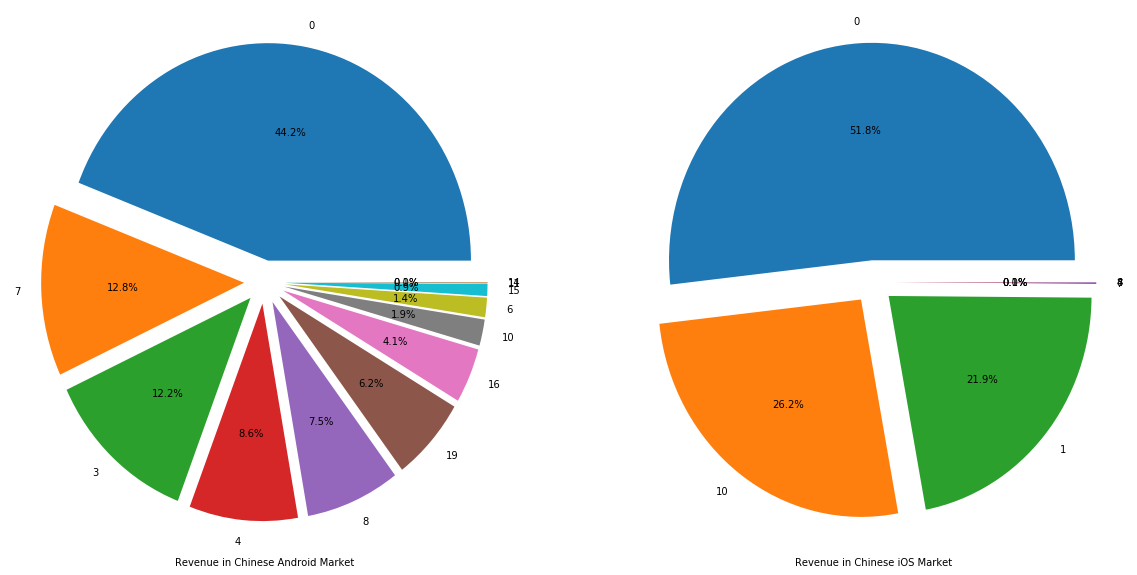

In [188]:
chinese_stores_performance_sql = """
select app_store_id,created_platform ,sum(iap_price_usd_cents) as store_revenue from(
        iap_purchase a
        left join account b
        on a.account_id = b.account_id)
        where country_code = 'CN'
        group by 1,2
        order by store_revenue desc
"""
chinese_stores_performance_pd = pd.read_sql_query(chinese_stores_performance_sql, conn)
android_markets = chinese_stores_performance_pd.ix[chinese_stores_performance_pd['created_platform'] == 'Android']
ios_markets = chinese_stores_performance_pd.ix[chinese_stores_performance_pd['created_platform'] == 'iOS']
f, (ax1,ax2) = plt.subplots(1, 2,  figsize=(20,10))

labels1 = list(android_markets['app_store_id'] )
explodes1 = [.1]*len(labels1)  
_ = ax1.pie(android_markets['store_revenue'], labels=labels1, autopct='%1.1f%%', explode=explodes1)
ax1.set_xlabel('Revenue in Chinese Android Market')

labels2 = list(ios_markets['app_store_id'] )
explodes2 = [.1]*len(labels2)  
_ = ax2.pie(ios_markets['store_revenue'], labels=labels2, autopct='%1.1f%%', explode=explodes2)
ax2.set_xlabel('Revenue in Chinese iOS Market')

Last but not least, we can get some ideas regarding the purchased products. The following figure depicts total count of purchased products (blue line) and products share (share). It is pretty interesting to observe that the *RED* dots (product **99a9e0e63...**) on average forms 30% of total purchases during the first 52 weeks of playing the game Additionally, it is puzzling to notice the peak regarding product **efd2eebfdc...** which happens in week 28. On the otehr hand the team needs to investigate why a product like **f822748f4b...** has never been a favorite one.

In [483]:
product_sql = """
select  product_id, week, count(product_id) as count
from(
        select a.account_id,
               a.package_id_hash as product_id,
               strftime('%Y-%m-%d', a.created_time) as purchase_date,
               strftime('%Y-%m-%d', b.created_time) as first_play_date,
               cast((julianday(strftime('%Y-%m-%d', a.created_time)) -
               julianday(strftime('%Y-%m-%d', b.created_time))) / 7 as int) as week       
        from (
                iap_purchase as a
                left join account as b
                on a.account_id = b.account_id
             )
     )
group by 1,2
"""
product_pd = pd.read_sql_query(product_sql, conn)


In [484]:
summarized_count_pd = product_pd.groupby('week', as_index=False).sum()[['week', 'count']]
# avoid column names with _x postfix, thus rename columns before join
summarized_count_pd.columns = ['week', 'week_total_count']
product_pd = product_pd.merge(right=summarized_count_pd, how='left', on='week').sort_values('week')
product_pd['percent'] = product_pd['count'].astype(float)/product_pd['week_total_count']

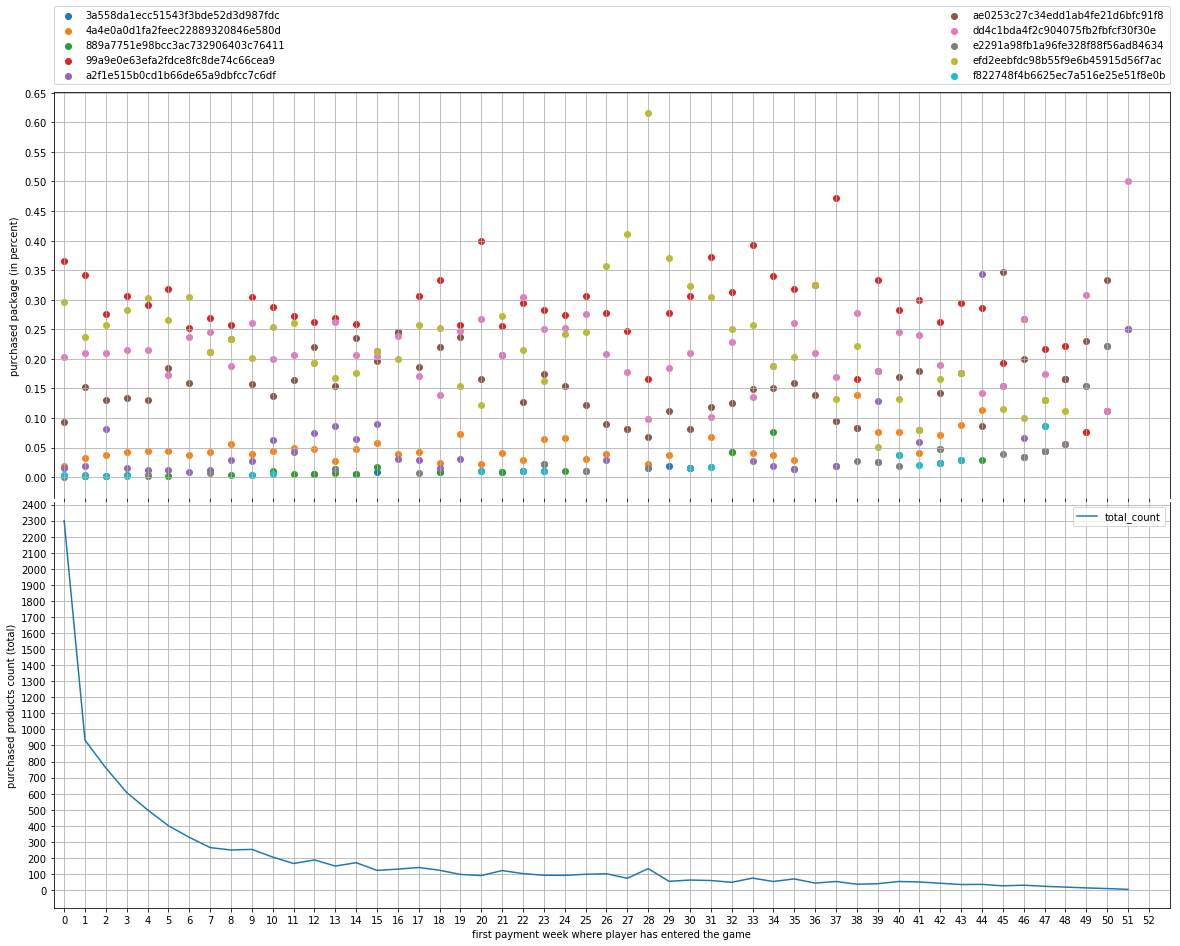

In [585]:
f, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(20,15))
f.subplots_adjust(hspace=0.01)
for group in product_pd.groupby('product_id'):
    tmp_pd = pd.DataFrame(group[1])
    ax.scatter(tmp_pd['week'], tmp_pd['percent'], label=group[0])

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.grid(True)
ax.set_xlim(-.5,53)
_ = ax.set_yticks(np.arange(0,.7, .05))
_ = ax.set_xticks(np.arange(0,53))
ax.set_ylabel('purchased package (in percent)')

ax.spines['bottom'].set_visible(False)

ax2.plot(summarized_count_pd['week_total_count'], label='total_count')
ax2.legend()
ax2.grid(True)
_ = ax2.set_yticks(np.arange(0,2500,100))
ax2.spines['top'].set_visible(False)
ax2.set_ylabel('purchased products count (total)')

ax2.set_xlabel('first payment week where player has entered the game')


**Conclusion**: All the performed analysis in trying to provide the game team with some insights regarding the neccessity of turinging a free user to a paying one during the first (5-8) weejs. It also tries to investigate how much time a user plays on average during the first weeks and also how much revenue is generated by the paying users who has started the first payment (and became a premium user) during the golden time mentioned above. At the end, the analysis tries to provide the team with some insights regarding the geographical splits of such premium users and also tries to investigate the popularity of purchased products during the first 52 weeks of joining the game.

Also, given more time and data. it would be interesting to do the following analysis as well:

* popularity of products in different countries so we can run a league in a diffrern country whcih makes players of that country to purchase those products more or push them in a way to purchase less popular products.

* emergin markets: for example which market have made the biggest growth during the last year



# Machine Learning

In this section we will try to train a classifier where it can classify free players as free/premimum, which mean that whether thery are going to turn to a premimum one based on their perfromance so far or they stay as free users!
The first step would be creating a data set. There is a fact that we need to notice a the beginning, we are dealing a hugely skewed data base. To be more accurate, the ratio of positive class (premium users) to the whole data sets (all the users that we have collected data for) is equal to the convergence rate, that is 0.013!
Based on this as the very first step, we will try to filter adn reduce the number of free users using some conditions. At the same time we need to keep an eye on the number of premimum user to not drop severly as the result of such conditioning and filtering. Last but not least, we need to bury in mind that the imposed conditions need to leave us with some meaningful critetion regarding the tas at hand. This is more like a grid search in order to find to find appropriate values for our training set.

In order to do such filtering we will get started with these factors that 1.how many days the user has played the game, and 2.total session time that player has spent in the game.

In [4]:
total_data_query = """ 
select count(account_id) from account_date_session 
        where account_id in(
                select account_id from
                (select account_id, 
                        sum(session_count) as sum_session, 
                        sum(session_duration_sec) as sum_duration,
                        count(account_id) as total_days
                from account_date_session
                group by account_id)
         
                where total_days > ? and sum_duration > ?
        )
        
group by account_id
"""

postivie_data_quey = """
select count(account_id) from(
        select account_id, count(account_id) as total_days, sum(session_duration_sec) as sum_duration, sum(session_count) as sum_session
                 from
                        (select a.account_id as account_id,
                         b.date as date,
                         b.session_count as session_count,
                         b.session_duration_sec as session_duration_sec 
                         from(
                        iap_purchase as a
                        left join account_date_session as b
                        on a.account_id = b.account_id)
                        ) as joint
        group by account_id)
        
        where total_days > ? and sum_duration > ?
group by account_id
"""



In [6]:
total_dataset_unique_ids_size = []
positive_dataset_unique_ids_size = []
days = np.arange(2,8)
session_time = np.arange(1800, 3601, 300)
for day in days:
    for time in session_time:
        print day, time
        tmp_total_size = pd.read_sql(total_data_query, con=conn, params=[day, time]).shape[0]
        total_dataset_unique_ids_size.append(tmp_total_size)
        
        tmp_total_positive = pd.read_sql(postivie_data_quey, con=conn, params=[day, time]).shape[0]
        positive_dataset_unique_ids_size.append(tmp_total_positive)

2 1800
2 2100
2 2400
2 2700
2 3000
2 3300
2 3600
3 1800
3 2100
3 2400
3 2700
3 3000
3 3300
3 3600
4 1800
4 2100
4 2400
4 2700
4 3000
4 3300
4 3600
5 1800
5 2100
5 2400
5 2700
5 3000
5 3300
5 3600
6 1800
6 2100
6 2400
6 2700
6 3000
6 3300
6 3600
7 1800
7 2100
7 2400
7 2700
7 3000
7 3300
7 3600


In [7]:
res = []
for day in days:
    for session in session_time:
        res.append(str(day) + '-' + str(session))

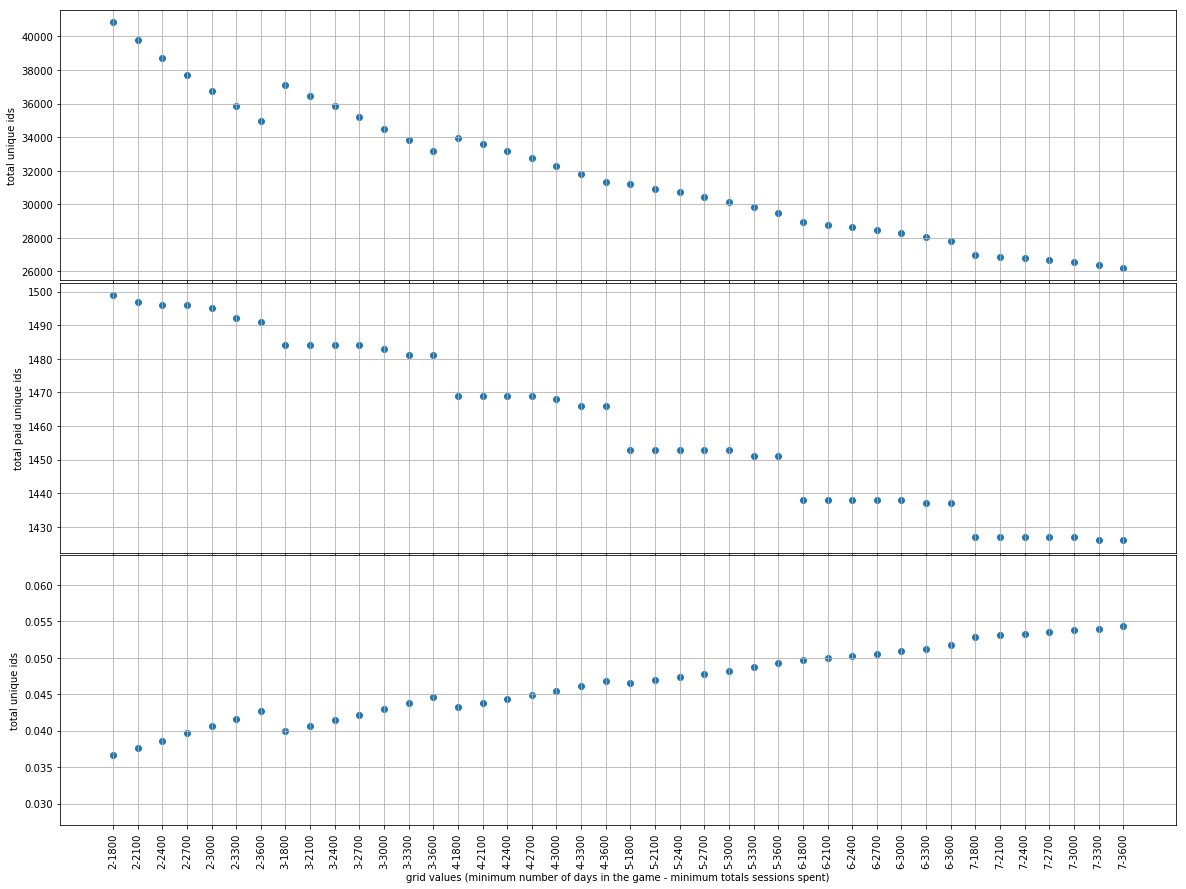

In [8]:
f, (ax1,ax2, ax3) =  plt.subplots(3,1,sharex=True, figsize=(20,15))
f.subplots_adjust(hspace=.01)
ax1.scatter(np.arange(0, len(res)), total_dataset_unique_ids_size)
ax1.grid(True)
ax1.set_ylabel('total unique ids')
ax2.scatter(np.arange(0, len(res)), positive_dataset_unique_ids_size)
ax2.grid(True)
ax2.set_ylabel('total paid unique ids')
ax3.scatter(np.arange(0, len(res)), np.array(positive_dataset_unique_ids_size, dtype=float)/ np.array(total_dataset_unique_ids_size))
ax3.grid(True)
ax3.set_ylabel('total unique ids')
_ = plt.xticks(np.arange(0, len(res)), res, rotation=90)
plt.xlabel('grid values (minimum number of days in the game - minimum totals sessions spent)')

Based on this, I will go for minimum days spent in the game = 6  and minim time spent in the game = 3600, which means that the player has played the game at least for 30 minutes. The reason behind this choise is that the ratio is not going to improve that much, and we have been able to mitigate the problem of having unlanced dataset (at least a little bit) by only losing a small number of paying samples in our minority class.

based on this I am goint to create a new table called modifie_account_date_session, based on teh above filter and use that for further analysis. Creating a new table in sqlite means that sqlite will restar the rowid, which will be used later for feature extraction. 

#### Any interesting features?

One feature which can be interesting is the longest number of consequtive days that the player has played the game. In order to do so we will use the following query using our new table, and of course, rowid!

Later we will read the data into pandas and continue from there.


In [6]:
c = conn.cursor()
c.execute("""
            create table modified_account_date_session_with_consecutive_dates as
            select * , (

                    select t2.date from modified_account_date_session as t2
                    where t2.account_id = t1.account_id
                          and t2.rowid = t1.rowid+1
                    ) as next_date
                    from modified_account_date_session t1
            order by account_id

          """)

NameError: name 'conn' is not defined

Also we need to read to read the different tables into pandas dataframe and calculate the date_diff columns which the difference between consecutive days that the player has played the game. Later we will use this column as one of the feature during training.

In [3]:
account_date_session_pd = pd.read_sql_query("""select * from modified_account_date_session_with_consecutive_dates"""
                                          , con=conn
                                          , parse_dates = {'date': "%Y-%m-%d", 'next_date':'%Y-%m-%d'})

account_date_session_pd['date_diff'] = (account_date_session_pd['next_date'] - account_date_session_pd['date'])/np.timedelta64(1, 'D')
accounst_pd = pd.read_sql_query("""select * from account""", con=conn)
iap_accounts_pd = pd.read_sql_query("""select account_id from iap_purchase group by account_id""", con=conn)

## Features:
As the final step in data collection process, we will summarise each user, and create a single row for each player and build our dataset. Here is where we cauculate different features. During this step we will calculate the following features:
* **date_diff**: which the difference between consective dates (in days) that the user has played thegae. Using this feature we will calculate some other features and drop it at the end. the following features are calculated based on date_diff:

    * **longest_seq**: which is the longest sequence of consequtive days that the player has played the game.
    * **shotest_seq**: shortes sequcnce of consequtive days that the player has played the game. 
    * **longest_gap**: the longest consecutive days that the user has not played the game.
    * **shortest_gap** : the shortest consecutive days that the player has not played the game.
* **avg_session_count**: average session count.
* **avg_duration**: average of session durations.
* **variance**: this is the variance of date_diff. It is used to represent how much a user sticks to the game.
* **game_age**: hwomany days the player has played the game.

AS the very final step in data collection, we will join this summarized user table with with accounts table in order to track the users's platform, country and appstore id used to create the account, thus as the result we will collect and use the following deatures as well:

* **created_platform**: the platform used to create the account
* **country_code**: the country in which the account has been created
* **appstore_id**: the appstore used to create the account. As appstore ids can be the same for diffrent countries, we will attach the country code to appstore_id the make the app_store id tied to country.


In [766]:


def summarise_user(df):
    
    date_diff = df.date_diff
    seq_of_ones = [len(list(group)) for key, group in itertools.groupby( df.date_diff.eq(1.0).tolist() ) if key ]
    
    if not seq_of_ones:
        longest_consecutive_days_played = 0
        shortest_consequtive_days_played = 0
    else:
        longest_consecutive_days_played = np.max(seq_of_ones)
        shortest_consequtive_days_played = np.min(seq_of_ones)
    
    
    gaps = date_diff.ix[date_diff != 1].dropna()
    
    
    if  gaps.empty:
        longest_gap = 0
        shortest_gap = 0
    else:
        longest_gap = np.max(gaps)
        shortest_gap = np.min(gaps)
    average_session_count = df.session_count.mean() 
    
    average_session_duration = df.session_duration_sec.mean()
    
    date_diff_variance = date_diff.var()
    game_age = df.shape[0]
    res =  pd.DataFrame([longest_consecutive_days_played, shortest_consequtive_days_played, longest_gap, shortest_gap
                         , average_session_count, average_session_duration, date_diff_variance, game_age]).T
    res.columns=['longest_seq', 'shotest_seq', 'longest_gap', 'shortest_gap', 'avg_session_count', 'avg_duration', 'variance', 'game_age']
    return res
    

In [768]:
summarized_uers = account_date_session_pd.groupby('account_id').apply(lambda x: summarise_user(x)).reset_index().drop('level_1', 1)

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [4]:
# save the data in case something goes wrong
#summarized_uers.to_pickle('./summarized_users_data_frame.pkl')
summarized_uers = pd.read_pickle('summarized_users_data_frame.pkl')

In [5]:
joint_summarized_uers = summarized_uers.merge(accounst_pd[['account_id', 'created_platform', 'country_code', 'created_app_store_id']], how='left', on ='account_id')\


joint_summarized_uers['created_app_store_id'] = joint_summarized_uers['country_code'] \
+ joint_summarized_uers['created_app_store_id'].astype(str)

Let's take a look at the data to make sure we are in a good shape

In [6]:
joint_summarized_uers.head()

account_id  longest_seq  shotest_seq  longest_gap  shortest_gap  \
0   12316528         87.0          1.0         10.0           2.0   
1   12318190          4.0          1.0          9.0           2.0   
2   12319852         80.0          1.0         51.0           2.0   
3   12321514        139.0          2.0         11.0           2.0   
4   12323730         30.0          1.0          7.0           2.0   

   avg_session_count  avg_duration   variance  game_age created_platform  \
0           2.858209   1213.925373   0.805764     134.0          Android   
1           1.500000    324.500000   6.090909      12.0          Android   
2           3.241026   1980.610256  16.174163     195.0          Android   
3          17.182371   6323.349544   0.511515     329.0              iOS   
4           1.471223    485.176259   0.588866     278.0          Android   

  country_code created_app_store_id  
0           US                  US2  
1           US                  US2  
2           AR                  AR2  
3           VN                  VN1  
4           KR                  KR2

As the next step we need to ddeal with categorical data at hand: created_platform, country_code, appstore_id. There are lots of options regarding dealing with categorical data. Here will will one-hot encode the data, which results in a huge sparse matrix regarding those features. As we are suffering severly from data scarcity and can not afford to learn from thsese sparse features, we will use principal component analysis (PCA) in order to reduce the dimention and later will pick the top **N** components which can explain 90% variance of the summarized data. AS the final step, using pca, I will reduce the dimention of the original one-hot-encoded featres  by transforming them.
 Let's take alook at the dimention before applying PCA:

In [7]:
platform_dummies = pd.get_dummies(joint_summarized_uers.created_platform)
country_code_dummies = pd.get_dummies(joint_summarized_uers.country_code, prefix='country_')
app_store_dummies = pd.get_dummies(joint_summarized_uers.created_app_store_id, prefix='store_')
binerized = platform_dummies.join(country_code_dummies).join(app_store_dummies)
print "Dimentions before applying PCA for one-hot-encoded features: ", binerized.shape

Dimentions before applying PCA for one-hot-encoded features:  (28947, 453)


In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60) # explains 90 % of data
pca.fit(binerized)
transformed_binerized = pca.fit_transform(binerized)

# make a copy of the training set -> attch the binerized and drop categorical data
data_set = joint_summarized_uers.copy()
data_set = data_set.drop('created_platform', axis=1).drop('country_code', axis=1).drop('created_app_store_id', axis=1)
binerized_df = pd.DataFrame(transformed_binerized)

# join the binary features 
data_set = data_set.join(binerized_df)

print "Dimentions before applying PCA for one-hot-encoded features: ", data_set.shape

Dimentions before applying PCA for one-hot-encoded features:  (28947, 69)


Let's creat the labels, Free_users=0, paid_users=1.
We will use iap_account_pd for our paid users and left join the data_set that we have obtaned so far with that (based on account_id) and then fill the NaN values with 0 for our free users. It is really important that we will drop the **Account_id** at the end!

In [9]:
# Lets' get back to to iap_account table and create a label for this data_frame. We will use label = 1
# for premium users and 0 for free users

iap_accounts_pd['label'] = 1

# now perform teh join 
data_set = data_set.merge(right=iap_accounts_pd[['account_id', 'label']], on='account_id', how='left')

data_set['label'] = data_set['label'].fillna(0)

#data_set = data_set.drop('label', axis=1)

# set the class label for NaN values

# and as the last step drop the account_id
data_set = data_set.drop('account_id', axis=1)



In [10]:
print 'Dimentions of the final dataset', data_set.shape
print 'class distribution:\n', data_set.label.value_counts()
print 'final dataset with ratio: %.3f' %(data_set.ix[data_set.label == 1].shape[0]/float((data_set.shape[0])))

Dimentions of the final dataset (28947, 69)
class distribution:
0.0    27543
1.0     1404
Name: label, dtype: int64
final dataset with ratio: 0.049


**let's address the elephant in the room. We have a super skewed (imbalanced) database where only 5% of the dataset is positve samples which needs to be used for training, validation and also testing. We are going to use different techniques to address this problem and will see how it ends.**

let's take a final look at the data:

In [11]:
data_set.head()

longest_seq  shotest_seq  longest_gap  shortest_gap  avg_session_count  \
0         87.0          1.0         10.0           2.0           2.858209   
1          4.0          1.0          9.0           2.0           1.500000   
2         80.0          1.0         51.0           2.0           3.241026   
3        139.0          2.0         11.0           2.0          17.182371   
4         30.0          1.0          7.0           2.0           1.471223   

   avg_duration   variance  game_age         0         1  ...          51  \
0   1213.925373   0.805764     134.0 -0.104264 -0.703262  ...    0.001003   
1    324.500000   6.090909      12.0 -0.104264 -0.703262  ...    0.001003   
2   1980.610256  16.174163     195.0 -0.238544 -0.410553  ...    0.013206   
3   6323.349544   0.511515     329.0  1.080341 -0.162220  ...    0.051732   
4    485.176259   0.588866     278.0 -0.244978 -0.450656  ...   -0.001185   

         52        53        54        55        56        57        58  \
0  0.000946  0.000519  0.000470  0.001234  0.001058  0.000390 -0.000347   
1  0.000946  0.000519  0.000470  0.001234  0.001058  0.000390 -0.000347   
2  0.001899 -0.008048  0.005350  0.010045 -0.003331 -0.000692 -0.006585   
3  0.029102  0.045087  0.047074  0.050578  0.075011  0.027191  0.009854   
4  0.023396  0.032344  0.001121  0.014748  0.016291  0.004164 -0.002410   

         59  label  
0  0.000069    0.0  
1  0.000069    0.0  
2  0.000693    0.0  
3  0.107027    0.0  
4  0.000772    0.0  

[5 rows x 69 columns]

Let's perform train_tes split

In [15]:
positive_samples = data_set.ix[data_set.label == 1]
negative_samples = data_set.ix[data_set.label == 0]

# create the test set and never touch that! we take 250 samples from each class and end up with a 
# test set of 750 elements!

test_positive = positive_samples.sample(n=250, replace=False)
test_negative = negative_samples.sample(n=250, replace=False)

# drop the elements of test sets from the original dataset
positive_samples = positive_samples.drop(test_positive.index)
negative_samples = negative_samples.drop(test_negative.index)

# perform a naive sanity chack and look at the numbers:
print ("new sizes: positive_samples: %d, negative_samples: %d,positive_test: %d, negative_test: %d" 
       %(positive_samples.shape[0], negative_samples.shape[0], test_positive.shape[0], test_negative.shape[0]))


# create test_set and train_set
shuffled = pd.concat([positive_samples, negative_samples]).sample(frac=1)
train_set = shuffled.drop('label', axis=1)
train_label = shuffled['label']

shuffled = pd.concat([test_positive, test_negative]).sample(frac=1)
test_set = shuffled.drop('label', axis=1)
test_label = shuffled['label']



print 'test_set class distribution \n', test_label.value_counts()
print 'train_set class distribution \n', train_label.value_counts()

# save everything inc asy anythong goes wrong
train_set.join(train_label).to_pickle('./train_set_pd')
test_set.join(test_label).to_pickle('./test_set_pd')

new sizes: positive_samples: 1154, negative_samples: 27293,positive_test: 250, negative_test: 250
test_set class distribution 
0.0    250
1.0    250
Name: label, dtype: int64
train_set class distribution 
0.0    27293
1.0     1154
Name: label, dtype: int64


we are in a good shape in order to embark on training a model. We can take different strategoes regarding the phenomenon at hand -- imbalanced dataset:

* over sample
* undersample
* Ignore the problem (I have not included this part in my report, but there is a longer version of this report where I have included some models trained on teh skewed dataset)



# Over Sampling

One of the methods to tackle the problem of imbalanced dataset is generating synthetic sample to represent the minority class in teh dataset. One integral point which needs to be observed during oversampling is that, the process of oversampling needs to be part of teh x-validation process. That is, one cat not perform over-sampling before x-validation as there is a great chance that oversampled data appear in the validation set, identically repeat in the train set and this can totally ruin the whole point of x-validation. In this section we will use a method called SMOTE (Synthetic Minority Over-sampling Technique)


In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
sm = SMOTE('minority')

In [17]:
train_set = pd.read_pickle('train_set_pd')
train_lable = train_set['label']
train_set.drop('label', axis=1, inplace=True)

test_set = pd.read_pickle('test_set_pd')
test_lable = test_set['label']
test_set.drop('label', axis=1, inplace=True)

oversampled_traning_set, oversampled_training_lable = sm.fit_sample(train_set, train_lable)

In [18]:
print "over-dampled data shapes:"
test_set.shape, test_lable.shape, train_set.shape, train_lable.shape, oversampled_traning_set.shape, oversampled_training_lable.shape


over-dampled data shapes:


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 11:38:32.416549. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


((500, 68), (500,), (28447, 68), (28447,), (54586, 68), (54586,))

As the firs step (and easiest one), let's use one of the off-the-shlef classifiers to perform the classification task.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
logit = LogisticRegressionCV()
logit.fit(oversampled_traning_set, oversampled_training_lable)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [19]:
print "logit accuracy on unseen data %.3f" %(logit.score(test_set, test_lable))
confusion_matrix(test_lable, logit.predict(test_set))

logit accuracy on unseen data 0.762


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-17 22:49:58.990580. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


array([[203,  47],
       [ 72, 178]])

It seems promising that we have been able to achieve such a perfomance at first attempt, let's train a decision tree using x-validation in order to tune max-depth parameter. (the first column is the maximu depth of the tree)

In [111]:
from sklearn.tree import DecisionTreeClassifier
k = 10
max_depth = 20

tree_val_acc_summary = []
tree_train_acc_summary = []

num_validation_samples = train_set.shape[0]/k

for depth in xrange(1, max_depth):
    tmp_val_acc = []
    tmp_train_acc = []
    
    for i in xrange(k):
        #print "starting fold %d" %i
        # as the first step separate the validation set and do not touch that at all
        val_data = train_set[i * num_validation_samples: (i+1)*num_validation_samples]
        val_labels = train_lable[i*num_validation_samples:(i+1)*num_validation_samples]
        
        train_set_res = np.concatenate([train_set[0: i * num_validation_samples]
                                     ,train_set[(i+1)*num_validation_samples:]], axis=0)

        train_lable_res = np.concatenate([train_lable[0: i * num_validation_samples],
                                          train_lable[(i+1)*num_validation_samples:]], axis=0)
        
        #now over sample teh data
        x_train_over_sampled, y_train_over_sampled = sm.fit_sample(train_set_res, train_lable_res)
        
        partial_training_data = np.concatenate([x_train_over_sampled[0: i * num_validation_samples]
                                                ,x_train_over_sampled[(i+1)*num_validation_samples:]], axis=0)
        
        
        partial_training_lables = np.concatenate([y_train_over_sampled[0: i * num_validation_samples],
                                                  y_train_over_sampled[(i+1)*num_validation_samples:]], axis=0)
        
        
        oversampled_traning_set, oversampled_training_lable  = sm.fit_sample(partial_training_data,
                                                                             partial_training_lables)
        
        
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(oversampled_traning_set, oversampled_training_lable)
        
        tmp_val_acc.append(dt.score(val_data, val_labels))
        tmp_train_acc.append(dt.score(oversampled_traning_set, oversampled_training_lable))
    
    print  "%d, val_acc %.3f, train_acc %.3f" %(depth, np.mean(tmp_val_acc),np.mean(tmp_train_acc))
    
    tree_val_acc_summary.append(np.mean(tmp_val_acc))
    tree_train_acc_summary.append(np.mean(tmp_train_acc))
    


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 00:29:56.538761. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


1, val_acc 0.640, train_acc 0.708
2, val_acc 0.806, train_acc 0.716
3, val_acc 0.699, train_acc 0.767
4, val_acc 0.790, train_acc 0.805
5, val_acc 0.838, train_acc 0.835
6, val_acc 0.892, train_acc 0.862
7, val_acc 0.899, train_acc 0.885
8, val_acc 0.913, train_acc 0.903
9, val_acc 0.918, train_acc 0.916
10, val_acc 0.928, train_acc 0.929
11, val_acc 0.936, train_acc 0.939
12, val_acc 0.938, train_acc 0.949
13, val_acc 0.935, train_acc 0.958
14, val_acc 0.932, train_acc 0.965
15, val_acc 0.932, train_acc 0.971
16, val_acc 0.930, train_acc 0.977
17, val_acc 0.928, train_acc 0.980
18, val_acc 0.924, train_acc 0.984
19, val_acc 0.924, train_acc 0.986


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 00:46:35.173480. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


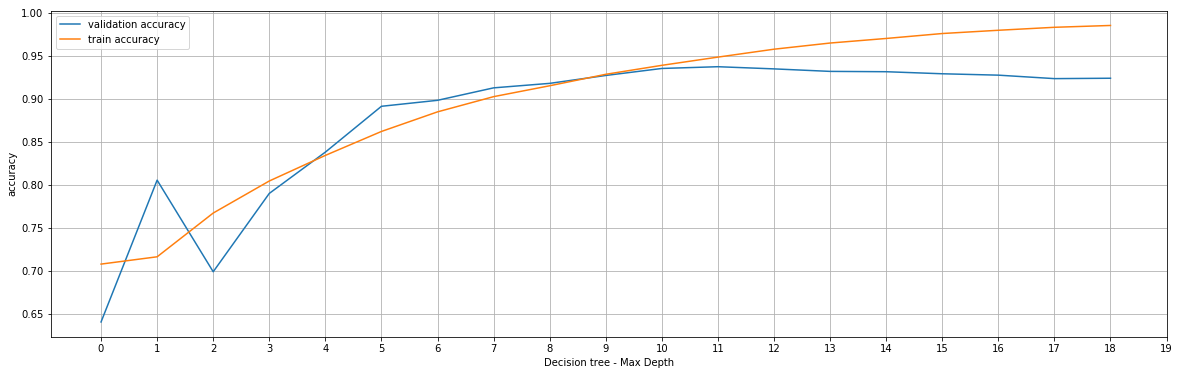

In [112]:
f, ax = plt.subplots(1,1)
ax.plot(tree_val_acc_summary, label='validation accuracy')
ax.plot(tree_train_acc_summary, label='train accuracy')
ax.grid(True)
ax.set_xticks(np.arange(0,20))
ax.legend()
ax.set_xlabel('Decision tree - Max Depth')
ax.set_ylabel('accuracy')


It seem that the tree start over fitting afrer depth 8, as the validation accuracy does not improve that much, while training set increases rapidly

In [131]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(oversampled_traning_set, oversampled_training_lable)

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 00:47:49.259311. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [132]:
print "decision tree accuracy on unseen data %.3f" %dt.score(test_set, test_lable)
print confusion_matrix(test_lable, dt.predict(test_set))

decision tree accuracy on unseen data 0.634
[[242   8]
 [175  75]]


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 00:47:51.753902. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


The accuracy is still good. Let's try to achieve higher accuracy with more complex model like Random Forest. Additionally, we will try to tune the parameters of RF with X-validation techniques (k = 10). we will try to tune the number of trees (estimators) as RF is an ensemle of decision trees.

In [139]:
from sklearn.ensemble import RandomForestClassifier


k = 10
n_trees = 20

rf_val_acc_summary = []
rf_train_acc_summary = []

num_validation_samples = train_set.shape[0]/k

for n_tree in xrange(10, n_trees):
    tmp_val_acc = []
    tmp_train_acc = []
    
    for i in xrange(k):
        
        # as the first step separate the validation set and do not touch that at all
        val_data = train_set[i * num_validation_samples: (i+1)*num_validation_samples]
        val_labels = train_lable[i*num_validation_samples:(i+1)*num_validation_samples]
        

        train_set_res = np.concatenate([train_set[0: i * num_validation_samples]
                                     ,train_set[(i+1)*num_validation_samples:]], axis=0)

        train_lable_res = np.concatenate([train_lable[0: i * num_validation_samples],
                                          train_lable[(i+1)*num_validation_samples:]], axis=0)
        #now over sample teh data
        x_train_over_sampled, y_train_over_sampled = sm.fit_sample(train_set_res, train_lable_res)
        
        partial_training_data = np.concatenate([x_train_over_sampled[0: i * num_validation_samples]
                                                ,x_train_over_sampled[(i+1)*num_validation_samples:]], axis=0)
        
        
        partial_training_lables = np.concatenate([y_train_over_sampled[0: i * num_validation_samples],
                                                  y_train_over_sampled[(i+1)*num_validation_samples:]], axis=0)
        
        
        oversampled_traning_set, oversampled_training_lable  = sm.fit_sample(partial_training_data,
                                                                             partial_training_lables)
        
        # max_depth=5 from the previous part
        rf = RandomForestClassifier(n_estimators=n_tree, n_jobs=-1, max_depth=8)
        rf.fit(oversampled_traning_set, oversampled_training_lable)
        
        tmp_val_acc.append(rf.score(val_data, val_labels))
        tmp_train_acc.append(rf.score(oversampled_traning_set, oversampled_training_lable))
    
    print  "n_estimators: %d, val_acc %.3f, train_acc %.3f" %(n_tree, np.mean(tmp_val_acc),np.mean(tmp_train_acc))
    
    rf_val_acc_summary.append(np.mean(tmp_val_acc))
    rf_train_acc_summary.append(np.mean(tmp_train_acc))
    

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 01:03:45.078516. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


n_estimators: 10, val_acc 0.918, train_acc 0.918
n_estimators: 11, val_acc 0.913, train_acc 0.916
n_estimators: 12, val_acc 0.915, train_acc 0.916
n_estimators: 13, val_acc 0.916, train_acc 0.919
n_estimators: 14, val_acc 0.917, train_acc 0.917
n_estimators: 15, val_acc 0.913, train_acc 0.916
n_estimators: 16, val_acc 0.920, train_acc 0.918
n_estimators: 17, val_acc 0.915, train_acc 0.918
n_estimators: 18, val_acc 0.919, train_acc 0.919
n_estimators: 19, val_acc 0.919, train_acc 0.919


It seem that the model has already overfit. Let's take a look at its performance over test set (unseen data)

In [140]:
print "Random Forest accuracy on unseen data %.3f" %rf.score(test_set, test_lable)
confusion_matrix(test_lable, rf.predict(test_set))

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 01:15:28.777910. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Random Forest accuracy on unseen data 0.602


array([[244,   6],
       [193,  57]])

It seem that the model has been able to generalize a little bit to the test set but the ensemle method has not been able to help us to its full potential as it is still performing poorly.

### Neural Nets and oversampled data
As we have over sampled the data, we might have enogh data to train a neural net. Let's see whether it can be helpful or not!
As the first step before using neural nets, we will white the data (zero mean, unit variance). Later we will use the following modls with RELUs as the activation function and sigmoid as the outpu layer activation. Let's take a look at the summary of the NN model.

In [5]:
os_nn2_model = models.Sequential()
os_nn2_model.add(layer=Dense(30, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
os_nn2_model.add(layer=Dense(20, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
os_nn2_model.add(layer=Dense(10, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
os_nn2_model.add(layer=Dense(5, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
os_nn2_model.add(layer=Dense(1, activation='sigmoid'))

os_nn2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
os_nn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                2070      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 2,961
Trainable params: 2,961
Non-trainable params: 0
_________________________________________________________________


In [5]:
mean = train_set.mean()
std = train_set.std()

train_set_white = train_set.sub(mean).div(std)

test_set_white = test_set.sub(mean).div(std)

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 02:19:38.718284. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Let's train the model with 10-fold x-validation

In [19]:

k = 10

nn2_history = []
num_validation_samples = train_set.shape[0]/k


for i in xrange(k):

    # as the first step separate the validation set and do not touch that at all
    val_data = train_set_white[i * num_validation_samples: (i+1)*num_validation_samples]
    val_labels = train_lable[i*num_validation_samples:(i+1)*num_validation_samples]

    # concat data
    partial_training_data = np.concatenate([train_set_white[0: i * num_validation_samples]
                                            ,train_set_white[(i+1)*num_validation_samples:]], axis=0)


    partial_training_lables = np.concatenate([train_lable[0: i * num_validation_samples],
                                              train_lable[(i+1)*num_validation_samples:]], axis=0)
    
    # now we can over sample
    x_train_over_sampled, y_train_over_sampled = sm.fit_sample(partial_training_data, partial_training_lables)
    

    # create the model
    os_nn2_model = models.Sequential()
    os_nn2_model.add(layer=Dense(30, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
    os_nn2_model.add(layer=Dense(20, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
    os_nn2_model.add(layer=Dense(10, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
    os_nn2_model.add(layer=Dense(5, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    os_nn2_model.add(layer=Dense(1, activation='sigmoid'))
    
    os_nn2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    history = os_nn2_model.fit(x_train_over_sampled,
                         y_train_over_sampled,
                         epochs=80,
                         batch_size=1024,
                         validation_data=(val_data.values, val_labels.values))

    
    nn2_history.append(history)


/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 07:07:16.063064. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Train on 49140 samples, validate on 2844 samples
Epoch 1/80
49140/49140 [==============================] - 0s - loss: 0.7001 - acc: 0.6673 - val_loss: 0.7198 - val_acc: 0.7250
Epoch 2/80
49140/49140 [==============================] - 0s - loss: 0.5901 - acc: 0.7643 - val_loss: 0.6191 - val_acc: 0.7356
Epoch 3/80
49140/49140 [==============================] - 0s - loss: 0.5400 - acc: 0.7787 - val_loss: 0.5740 - val_acc: 0.7271
Epoch 4/80
49140/49140 [==============================] - 0s - loss: 0.5156 - acc: 0.7862 - val_loss: 0.5366 - val_acc: 0.7447
Epoch 5/80
49140/49140 [==============================] - 0s - loss: 0.5007 - acc: 0.7910 - val_loss: 0.5283 - val_acc: 0.7458
Epoch 6/80
49140/49140 [==============================] - 0s - loss: 0.4900 - acc: 0.7953 - val_loss: 0.5000 - val_acc: 0.7535
Epoch 7/80
49140/49140 [==============================] - 0s - loss: 0.4811 - acc: 0.7976 - val_loss: 0.5213 - val_acc: 0.7426
Epoch 8/80
49140/49140 [==============================] - 0s -

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 09:29:35.246724. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


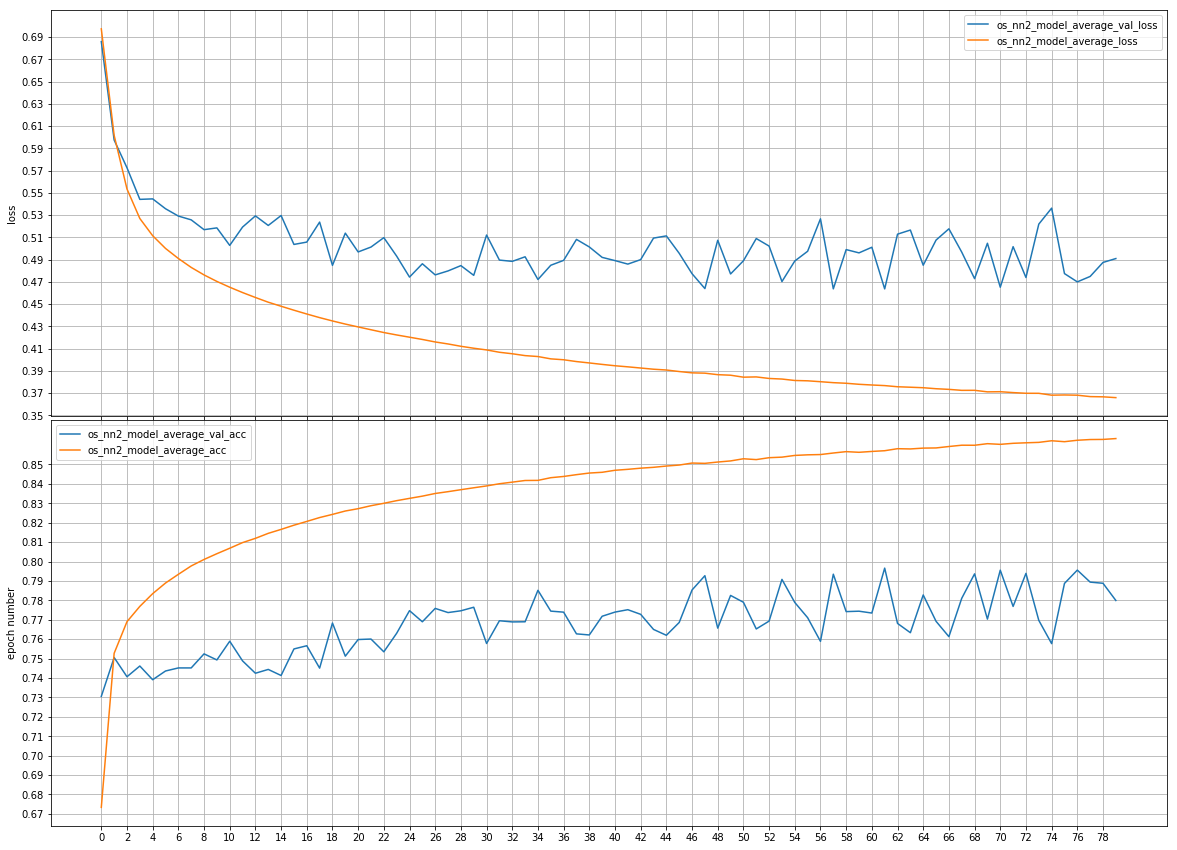

In [65]:
fig, (ax, ax1) = plt.subplots(2,1, sharex=True, figsize=(20,15))
fig.subplots_adjust(hspace=0.01)
os_nn2_model_average_val_loss =  np.mean([his.history['val_loss'] for his in nn2_history], axis=0)
os_nn2_model_average_loss =  np.mean([his.history['loss'] for his in nn2_history], axis=0)
ax.plot(os_nn2_model_average_val_loss, label='os_nn2_model_average_val_loss')
ax.plot(os_nn2_model_average_loss, label='os_nn2_model_average_loss')
ax.grid(True)
ax.set_ylabel('loss')
ax.legend()
_ = ax.set_yticks(np.arange(.35, .71, .02))

os_nn2_model_average_val_acc =  np.mean([his.history['val_acc'] for his in nn2_history], axis=0)
os_nn2_model_average_acc =  np.mean([his.history['acc'] for his in nn2_history], axis=0)
ax1.plot(os_nn2_model_average_val_acc, label='os_nn2_model_average_val_acc')
ax1.plot(os_nn2_model_average_acc, label='os_nn2_model_average_acc')
ax1.grid(True)
ax1.set_ylabel('accuracy')
ax1.set_ylabel('epoch number')
ax1.set_yticks(np.arange(0.67,.86,.01))
ax1.legend()

_ = ax1.set_xticks(np.arange(0,80,2))

It seems that after epoch 47 the accuracy loss (ac validation accuracy) is not improving that much and model start overfitting (as training accuracy increases). Thus let's retraing a new model until epoch 47!

In [10]:
final_os_nn2_model = models.Sequential()
final_os_nn2_model.add(layer=Dense(30, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
final_os_nn2_model.add(layer=Dense(20, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
final_os_nn2_model.add(layer=Dense(10, activation='relu', input_shape=(68,),kernel_regularizer=regularizers.l2(0.001)))
final_os_nn2_model.add(layer=Dense(5, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
final_os_nn2_model.add(layer=Dense(1, activation='sigmoid'))
    
final_os_nn2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
final_os_nn2_model.fit(oversampled_traning_set,
                     oversampled_training_lable,
                     epochs=47,
                     batch_size=32,verbose=0)


Let's take a look at the test accuracy

In [67]:
accuracy_score(test_lable, np.round(final_os_nn2_model.predict(test_set.values)))

/Users/aminsorkhei/anaconda/envs/tensorflow/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-18 09:30:26.264135. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


0.73599999999999999

It seems pretty promising, it seems that as we have enough data and NN is well known for self feature engineering, it has been able to generalize pretty well to the unseen data as well!

# Undersampling

In order to do undersampling regarding the majority class, we will run clustering (mini-batch clustering in order to speed up everything) where number of clusters is qual to the desired number of under sampled instances. By the way of example, if the major class has 10K instance and we need to down sample that to 1K instances, we will run a clustering algorithm with 1K clusters(centroids) on sample with majority lable. As teh next step, we will find the nearest points from the major samples to these centroids and pick these sample as the representative of the whole majority class.


Through this section, we will first reduce the dimentionality of the trainset so we can plot them in 2D, just to get a fealing about structure of the data. Later, we will run k-means, pick the centroids, pick the nearest points and reduce their dumention and plot them once more, in order to see whther the under sampled class really represent the samples of original major class  or not!

In [3]:
train_set = pd.read_pickle('train_set_pd')
train_lable = train_set['label']
train_set.drop('label', axis=1, inplace=True)

test_set = pd.read_pickle('test_set_pd')
test_lable = test_set['label']
test_set.drop('label', axis=1, inplace=True)

In [25]:
# negative_sammples as the major class
negative_samples = train_set.ix[train_lable[train_lable == 0].index]

# as the number of centroid 
minor_class_size = train_set.ix[train_lable[train_lable == 1].index].shape[0] + 50

# run mini-batch kmeans as it is faster than normal kmeans
mkmeans = MiniBatchKMeans(n_clusters=minor_class_size)
mkmeans.fit(negative_samples)
centroids = mkmeans.cluster_centers_

In [26]:
# perform dimentionality reduction
pca2 = PCA(n_components=2)
pca2.fit(negative_samples)
transofrmed = pca2.transform(train_set)
print "explained_ratio using the firs 2 components %f" %np.cumsum(pca2.explained_variance_ratio_)[-1]

explained_ratio using the firs 2 components 0.994404


Let's plot the data in reduced dimention!

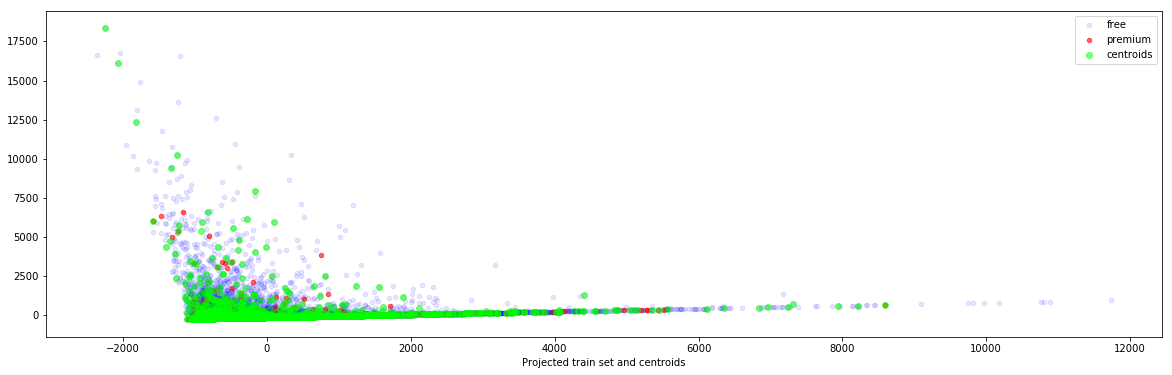

In [27]:
# transfer and plot points
# transform centroids so we can plot them as well
transformed_centroids = pca2.transform(centroids)

transofrmed_pd = pd.DataFrame(transofrmed)
transofrmed_pd.set_index(train_lable.index)

positives = transofrmed_pd.ix[train_lable.ix[train_lable == 1].index]
negatives = transofrmed_pd.ix[train_lable.ix[train_lable == 0].index]

f, ax = plt.subplots(1,1)
negatives.plot(x=0, y=1, label='free', kind='scatter', ax=ax,color =  (0, 0, 1, 0.1))
positives.plot(x=0, y=1, label='premium', kind='scatter', ax=ax,color =  (1, 0, 0, 0.6))

ax.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], color=(0, 1, 0, 0.5), label = 'centroids')
ax.legend()
ax.set_xlabel("Projected train set and centroids")
ax.set_ylabel(" ")

Now let's find the representatives, by finding the closest points to centroids:

In [28]:
# Calculate l2 distance between centroids and all teh points
indices = np.argmin(cdist(centroids, negative_samples), axis=1)

# pick the points based on their indices
undersampled_negative_samples = negative_samples.values[indices, :]

Let's plot selected centroids and the original major class samples, to see how whell they are covered

In [29]:
undersampled_negative_samples = pd.DataFrame(undersampled_negative_samples)
undersampled_negative_samples.columns = train_set.columns
undersampled_negative_samples['label'] = 0

In [30]:
under_sampled_train_set = pd.concat(objs=[train_set.join(train_lable).ix[train_lable[train_lable == 1].index],
                                          undersampled_negative_samples]).sample(frac=1)
under_sampled_train_lable = under_sampled_train_set['label']
under_sampled_train_set.drop('label', axis=1, inplace=True)

Let's take a look athe class distribution in the under sampled data

In [31]:
under_sampled_train_lable.value_counts()

0.0    1204
1.0    1154
Name: label, dtype: int64

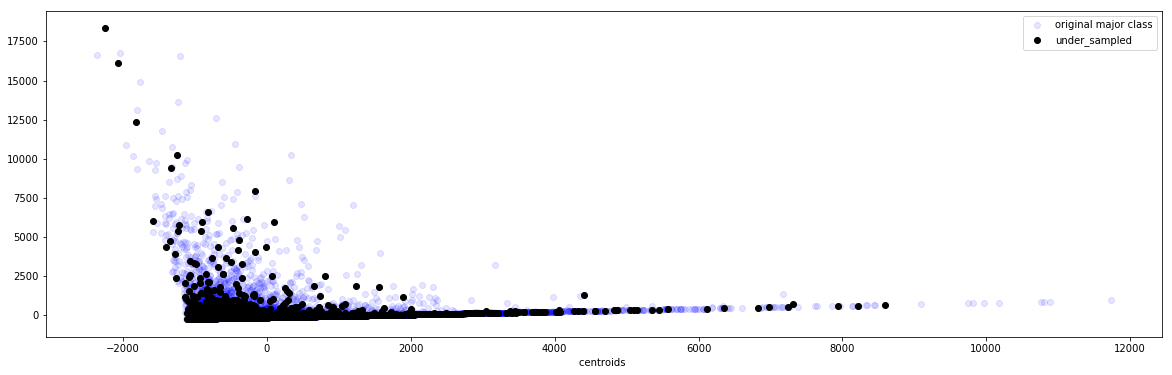

In [32]:
undersampled_negative_samples_transfered = pca2.transform(undersampled_negative_samples.drop('label', axis=1))

f, ax = plt.subplots(1,1)
ax.scatter(negatives[0], negatives[1], color=(0, 0, 1, 0.1), label='original major class')
ax.scatter(undersampled_negative_samples_transfered[:,0], undersampled_negative_samples_transfered[:,1],
            color=(0, 0, 0, 1), label = 'under_sampled', marker='o')

ax.set_xlabel('centroids ')
ax.legend()






centroids' neighbors from the major class are representing the major samples to a good extend!
Let's train some models.

In [33]:
us_logit = LogisticRegressionCV()
us_logit.fit(under_sampled_train_set, under_sampled_train_lable)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [34]:
print "under_sampled logit accuracy on unseen data %.3f" %(us_logit.score(test_set, test_lable))
confusion_matrix(test_lable, us_logit.predict(test_set))

under_sampled logit accuracy on unseen data 0.728


array([[185,  65],
       [ 71, 179]])

It seems that logit is still performing pretty close to the logit trained on over_sampled data! Let's train a decision tree using x-validation on under-sampled data.

In [35]:
k = 10
max_depth = 20

us_tree_val_acc_summary = []
us_tree_train_acc_summary = []

num_validation_samples = under_sampled_train_set.shape[0]/k


for depth in xrange(1, max_depth):
    tmp_val_acc = []
    tmp_train_acc = []
    
    for i in xrange(k):
        
        val_data = under_sampled_train_set[i * num_validation_samples: (i+1)*num_validation_samples]
        val_labels = under_sampled_train_lable[i*num_validation_samples:(i+1)*num_validation_samples]
        

        partial_training_data = np.concatenate([under_sampled_train_set[0: i * num_validation_samples]
                                                ,under_sampled_train_set[(i+1)*num_validation_samples:]], axis=0)
        
        
        partial_training_lables = np.concatenate([under_sampled_train_lable[0: i * num_validation_samples],
                                                  under_sampled_train_lable[(i+1)*num_validation_samples:]], axis=0)
        
        
        
        
        
        us_dt = DecisionTreeClassifier(max_depth=depth)
        us_dt.fit(partial_training_data, partial_training_lables)
        
        tmp_val_acc.append(us_dt.score(val_data, val_labels))
        tmp_train_acc.append(us_dt.score(partial_training_data, partial_training_lables))
    
    print  "depth %d, val_acc %.3f, train_acc %.3f" %(depth, np.mean(tmp_val_acc),np.mean(tmp_train_acc))
    
    us_tree_val_acc_summary.append(np.mean(tmp_val_acc))
    us_tree_train_acc_summary.append(np.mean(tmp_train_acc))
    

depth 1, val_acc 0.614, train_acc 0.623
depth 2, val_acc 0.671, train_acc 0.683
depth 3, val_acc 0.689, train_acc 0.709
depth 4, val_acc 0.686, train_acc 0.729
depth 5, val_acc 0.683, train_acc 0.745
depth 6, val_acc 0.690, train_acc 0.769
depth 7, val_acc 0.693, train_acc 0.791
depth 8, val_acc 0.684, train_acc 0.816
depth 9, val_acc 0.684, train_acc 0.840
depth 10, val_acc 0.674, train_acc 0.864
depth 11, val_acc 0.670, train_acc 0.885
depth 12, val_acc 0.672, train_acc 0.905
depth 13, val_acc 0.663, train_acc 0.922
depth 14, val_acc 0.662, train_acc 0.937
depth 15, val_acc 0.659, train_acc 0.951
depth 16, val_acc 0.652, train_acc 0.962
depth 17, val_acc 0.646, train_acc 0.970
depth 18, val_acc 0.642, train_acc 0.978
depth 19, val_acc 0.649, train_acc 0.984


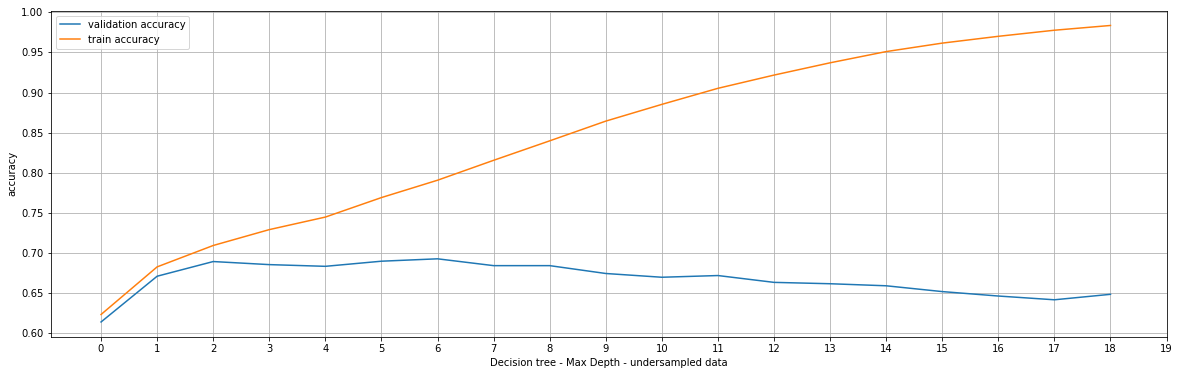

In [36]:
f, ax = plt.subplots(1,1)
ax.plot(us_tree_val_acc_summary, label='validation accuracy')
ax.plot(us_tree_train_acc_summary, label='train accuracy')
ax.grid(True)
ax.set_xticks(np.arange(0,20))
ax.legend()
ax.set_xlabel('Decision tree - Max Depth - undersampled data')
ax.set_ylabel('accuracy')

Clearly teh model start overfitting when it goes beyond depth 6!, Let's train a decisiont tree with max depth limited to 6!

In [37]:
us_dt = DecisionTreeClassifier(max_depth=6)
us_dt.fit(under_sampled_train_set, under_sampled_train_lable)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
print "under sampled decision tree accuracy on unseen data %.3f" %us_dt.score(test_set, test_lable)
confusion_matrix(test_lable, us_dt.predict(test_set))

under sampled decision tree accuracy on unseen data 0.732


array([[170,  80],
       [ 54, 196]])

This sound pretty promising as compared to decision tree trained on over_sampled data! Let's see whetehr the Random Forest can help us or not!

In [43]:
k = 10
n_trees = 15

us_rf_val_acc_summary = []
us_rf_train_acc_summary = []

num_validation_samples = under_sampled_train_set.shape[0]/k

for depth in range(5,10):
    for n_tree in xrange(5, n_trees):
        tmp_val_acc = []
        tmp_train_acc = []

        for i in xrange(k):

            # as the first step separate the validation set and do not touch that at all
            val_data = under_sampled_train_set[i * num_validation_samples: (i+1)*num_validation_samples]
            val_labels = under_sampled_train_lable[i*num_validation_samples:(i+1)*num_validation_samples]



            partial_training_data = np.concatenate([under_sampled_train_set[0: i * num_validation_samples]
                                                    ,under_sampled_train_set[(i+1)*num_validation_samples:]], axis=0)


            partial_training_lables = np.concatenate([under_sampled_train_lable[0: i * num_validation_samples],
                                                      under_sampled_train_lable[(i+1)*num_validation_samples:]], axis=0)




            us_rf = RandomForestClassifier(n_estimators=n_tree, n_jobs=-1, max_depth=depth)
            us_rf.fit(partial_training_data, partial_training_lables)

            tmp_val_acc.append(us_rf.score(val_data, val_labels))
            tmp_train_acc.append(us_rf.score(partial_training_data, partial_training_lables))

        print  "depth %d,n_estimators: %d, val_acc %.3f, train_acc %.3f" %(depth,
                                                                          n_tree,
                                                                          np.mean(tmp_val_acc),
                                                                          np.mean(tmp_train_acc))

        us_rf_val_acc_summary.append(np.mean(tmp_val_acc))
        us_rf_train_acc_summary.append(np.mean(tmp_train_acc))
    

depth 5,n_estimators: 5, val_acc 0.707, train_acc 0.746
depth 5,n_estimators: 6, val_acc 0.709, train_acc 0.746
depth 5,n_estimators: 7, val_acc 0.704, train_acc 0.748
depth 5,n_estimators: 8, val_acc 0.712, train_acc 0.751
depth 5,n_estimators: 9, val_acc 0.707, train_acc 0.754
depth 5,n_estimators: 10, val_acc 0.707, train_acc 0.753
depth 5,n_estimators: 11, val_acc 0.703, train_acc 0.753
depth 5,n_estimators: 12, val_acc 0.709, train_acc 0.754
depth 5,n_estimators: 13, val_acc 0.709, train_acc 0.754
depth 5,n_estimators: 14, val_acc 0.711, train_acc 0.756
depth 6,n_estimators: 5, val_acc 0.696, train_acc 0.762
depth 6,n_estimators: 6, val_acc 0.703, train_acc 0.766
depth 6,n_estimators: 7, val_acc 0.703, train_acc 0.765
depth 6,n_estimators: 8, val_acc 0.702, train_acc 0.767
depth 6,n_estimators: 9, val_acc 0.707, train_acc 0.770
depth 6,n_estimators: 10, val_acc 0.710, train_acc 0.771
depth 6,n_estimators: 11, val_acc 0.707, train_acc 0.769
depth 6,n_estimators: 12, val_acc 0.706, 

We are experiencing the same problem thaat we experienced for oversampled data with random forest (while the average val accuracy). The interesting observation is that, as we let the trees to go deeper, they only result in overfitting, as calidation accuracy does not change that much , while training accuracy increases!

In [51]:
us_rf = RandomForestClassifier(n_estimators = 5, max_depth=8)
us_rf.fit(under_sampled_train_set, under_sampled_train_lable)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
print "under sample Random Forest accuracy on unseen data %.3f" %us_rf.score(test_set, test_lable)
confusion_matrix(test_lable, us_rf.predict(test_set))

under sample Random Forest accuracy on unseen data 0.748


array([[168,  82],
       [ 44, 206]])

In **conclusion** , it seems thtat the undersampling method is working better as it enables the model to generalize better. (excluding the NN trained on over-sampled data)

Given more time and data, we might be able to run some ML algorithm targeted around paying users (payer clustering). By the way of example we can represent payers by a normalized vector of products that they have purchased so far and then cluster them into groups. This way we can find the shopping bags/behavious of different cluster of users, which can be quite informative and useful.